In [1]:
"""
This experiment uses hashprint without delta feature + dropout 80% + batchnorm.
"""

'\nThis experiment uses hashprint without delta feature + dropout 80% + batchnorm.\n'

In [2]:
# Set the experiment name to be something meaningful. 
# It will be part of the name of the model to be saved.
EXPERIMENT_NAME = "[HashNet-100-iteration-dropout-80-batchnorm]"
DEBUG = True        # Set to True if you want to see outputs used for debugging 
verbose = False      # Set to True if you want to see the loss function per epoch in real time

In [3]:
from IPython.display import SVG

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Concatenate, Layer, GaussianNoise, BatchNormalization
from keras.applications import vgg19
from keras.utils import plot_model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

import sys
import datetime
import keras
import pickle
import logging
import h5py
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.io

from songdb import data_dict
from preprocess import preprocess
from model import build_model

%matplotlib inline

/home/mjenrungrot/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
logger = logging.getLogger()

# File Handler
fhandler = logging.FileHandler(filename='{:}.log'.format(EXPERIMENT_NAME), mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

# Output stream Handler
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(formatter)
logger.addHandler(ch)

if DEBUG: 
    logger.setLevel(logging.DEBUG)
    ch.setLevel(logging.DEBUG)
else:     
    logger.setLeveL(logging.INFO)
    ch.setLevel(logging.INFO)

## Config Keras

In this code, we will use tensorflow backend on Keras because it's relatively faster than Theano. We'll use the image data format in the form of `(n_channel, width, height)`. Please look at the Keras documentation for more details.

In [5]:
assert K.backend() == 'tensorflow'
logger.debug("Keras backend is tensorflow.")

K.set_image_data_format('channels_first')
assert K.image_data_format() == 'channels_first'
logger.debug("Keras image data format is channels_first")

2018-03-08 00:15:31,838 - root - DEBUG - Keras backend is tensorflow.
2018-03-08 00:15:31,840 - root - DEBUG - Keras image data format is channels_first


## Load dataset
We load the pair-annotation dataset. Here, we generate an array of of shapes `(n_pairs, 2, 76, 121)`.

In [6]:
logger.debug("Load Paired-annotation data")
data = data_dict()
logger.debug("\t data.type = {:}".format(type(data)))
logger.debug("\t data = {:}".format(data))
ref_query_pairs = data['taylorswift']

songPairs = []
totalPairs = 0 
for ref, query in ref_query_pairs:
    # Get pairs for each ref + query
    curr_pairs = []
    for i in range(ref.shape[0]):
        refQ = preprocess(librosa.cqt(np.asfarray(ref[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        queryQ = preprocess(librosa.cqt(np.asfarray(query[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        Q_pair = np.append(np.array([refQ]), np.array([queryQ]), axis=0)[np.newaxis, :]
        curr_pairs.append(Q_pair)
    curr_pairs = np.vstack(tuple(curr_pairs))
    totalPairs += curr_pairs.shape[0]
    songPairs.append(curr_pairs)
    logger.debug("Song {:}: Finish current pairs with shape = {:}".format(len(songPairs), curr_pairs.shape))
    logger.debug("Number of samples for the current song: {:}".format(len(curr_pairs)))

logger.debug("There are {:} number of pairs".format(totalPairs))

2018-03-08 00:15:31,903 - root - DEBUG - Load Paired-annotation data
2018-03-08 00:15:31,904 - root - DEBUG - 	 data.type = <class 'dict'>
2018-03-08 00:15:31,905 - root - DEBUG - 	 data = {'taylorswift': <generator object get_ref_query_pairs at 0x7f4fab28a728>}


/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.d

2018-03-08 00:15:53,490 - root - DEBUG - Song 1: Finish current pairs with shape = (272, 2, 76, 121)
2018-03-08 00:15:53,493 - root - DEBUG - Number of samples for the current song: 272
2018-03-08 00:16:12,998 - root - DEBUG - Song 2: Finish current pairs with shape = (264, 2, 76, 121)
2018-03-08 00:16:12,999 - root - DEBUG - Number of samples for the current song: 264
2018-03-08 00:16:20,251 - root - DEBUG - Song 3: Finish current pairs with shape = (100, 2, 76, 121)
2018-03-08 00:16:20,252 - root - DEBUG - Number of samples for the current song: 100
2018-03-08 00:16:27,856 - root - DEBUG - Song 4: Finish current pairs with shape = (100, 2, 76, 121)
2018-03-08 00:16:27,861 - root - DEBUG - Number of samples for the current song: 100
2018-03-08 00:16:44,314 - root - DEBUG - Song 5: Finish current pairs with shape = (221, 2, 76, 121)
2018-03-08 00:16:44,315 - root - DEBUG - Number of samples for the current song: 221
2018-03-08 00:17:03,020 - root - DEBUG - Song 6: Finish current pairs 

In [7]:
p_train = .6
cutOffIdx = 0
currentNumberOfPairs = 0
for song in songPairs:
    currentNumberOfPairs += song.shape[0]
    cutOffIdx += 1
    if currentNumberOfPairs >= totalPairs * p_train:
        break

data_train = tuple(songPairs[:cutOffIdx])
data_val = tuple(songPairs[cutOffIdx:])
logger.debug("Finish loading paired-annotation data")
logger.debug("=> There are {:} songs for training [{:.2f} percent]".format(len(data_train), (currentNumberOfPairs/totalPairs * 100.0)))
logger.debug("=> There are {:} songs for validation".format(len(data_val)))

2018-03-08 00:17:34,589 - root - DEBUG - Finish loading paired-annotation data
2018-03-08 00:17:34,593 - root - DEBUG - => There are 6 songs for training [74.05 percent]
2018-03-08 00:17:34,598 - root - DEBUG - => There are 2 songs for validation


## Preprocessing
Obtain a matrix $X_1$, $X_2$, $[w_{ij}]$, and $[s_{ij}]$ where $X_1$ and $X_2$ are pairs of images of shape 
`(n_samples, 1, width, height)`; $[w_{ij}]$ is the weight vector of shape `(n_samples, 1)` which describes the weight of each pair; and $[s_{ij}]$ is a binary vector of shape `(n_samples,1)` indicating whether inputs $i$ and $j$ are the same.

__Add similar pairs__

We add similar pairs based on the dataset we have.

__Add non-similar pairs__

We add non-similar pairs by randomly selecting two CQT frames from the dataset. Note that we say two CQT pairs are not similar when they come from different songs only.

__Data Post-processing__

Convert $X_1$, $X_2$, $[s_{ij}]$ in to numpy arrays.

__Calculate weights__

Calculate the weight vector $[w_{ij}]$. The term $w_{ij}$ is defined as 

$$
    w_{ij} = \begin{cases}
    \frac{|S|}{|S_{1}|} &\text{if $x^{(i)}$ is similar to $x^{(j)}$}\\
    \frac{|S|}{|S_{0}|} &\text{if $x^{(i)}$ is not similar to $x^{(j)}$}
    \end{cases}
$$

In [8]:
def generate_training_data(data, nNonSimilar=1000):
#     nPairs = data.shape[0] 
    X1 = []
    X2 = []
    S = []
    groundTruth = []
    
    # add similar pairs
    for songId in range(len(data)):
        nPairs = data[songId].shape[0]
        for idx in range(nPairs):
            X1.append(np.expand_dims(data[songId][idx][0][:][:], axis=0))
            X2.append(np.expand_dims(data[songId][idx][1][:][:], axis=0))
            groundTruth.append(((songId,idx),(songId,idx)))
            S.append(True)
        
    # add non-similar pairs
    for i in range(nNonSimilar):
        [songId1, songId2] = np.random.choice(len(data), 2, replace=False)
        nPairs1 = data[songId1].shape[0]
        nPairs2 = data[songId2].shape[0]

        [idx1] = np.random.choice(nPairs1, 1)
        [idx2] = np.random.choice(nPairs2, 1)
        X1.append(np.expand_dims(data[songId1][idx1][0][:][:], axis=0))
        X2.append(np.expand_dims(data[songId2][idx2][1][:][:], axis=0))
        S.append((songId1,idx1) == (songId2,idx2))
        groundTruth.append(((songId1,idx1),(songId2,idx2)))
        
    # post-processing
    X1 = np.array(X1)
    X2 = np.array(X2)
    S = np.array(S).reshape(-1,1)
    # calculate weights
    n_sim = len(S[S==True])
    w_sim   = len(X1) / n_sim             # w_ij for similar pairs
    w_insim = len(X1) / (len(X1) - n_sim)  # w_ij for dissimilar pairs
    W = S*w_sim + (~S)*w_insim          # w vector for pairs
    S = S.astype('float32')
    
    logger.debug("X1 shape: {:}".format(X1.shape))
    logger.debug("X2 shape: {:}".format(X2.shape))
    logger.debug("S shape: {:}".format(S.shape))
    logger.debug("W shape: {:}".format(W.shape))
    logger.debug("There are {:} out of {:} pairs that are similar [{:.2f} percent]".format(n_sim, 
                                                                                           len(X1),
                                                                                           100.0*n_sim/len(X1)))
    
    return X1, X2, S, W, groundTruth

In [9]:
X1, X2, S, W, groundTruth = generate_training_data(data_train)
X1_val, X2_val, S_val, W_val, groundTruth_val = generate_training_data(data_val)

2018-03-08 00:17:34,980 - root - DEBUG - X1 shape: (2210, 1, 76, 121)
2018-03-08 00:17:34,981 - root - DEBUG - X2 shape: (2210, 1, 76, 121)
2018-03-08 00:17:34,982 - root - DEBUG - S shape: (2210, 1)
2018-03-08 00:17:34,983 - root - DEBUG - W shape: (2210, 1)
2018-03-08 00:17:34,983 - root - DEBUG - There are 1210 out of 2210 pairs that are similar [54.75 percent]
2018-03-08 00:17:35,145 - root - DEBUG - X1 shape: (1424, 1, 76, 121)
2018-03-08 00:17:35,146 - root - DEBUG - X2 shape: (1424, 1, 76, 121)
2018-03-08 00:17:35,147 - root - DEBUG - S shape: (1424, 1)
2018-03-08 00:17:35,148 - root - DEBUG - W shape: (1424, 1)
2018-03-08 00:17:35,149 - root - DEBUG - There are 424 out of 1424 pairs that are similar [29.78 percent]


In [10]:
nPairs = X1.shape[0]

## Model

__Define inputs__

Create a HashNet model with four inputs: two images tensors, similarity vector, and weight vector.

In [11]:
width = 76
height = 121
n_channel = 1

In [12]:
image_a    = Input(shape=(n_channel, width, height), name='image_1')
image_b    = Input(shape=(n_channel, width, height), name='image_2')
similarity = Input(shape=(1,), name="similarity")
weight     = Input(shape=(1,), name="weight")

__Pre-trained model__

Use a pre-trained model here to obtain intermediate values from the pre-trained model. We call this pre-trained model by `base_model`. The `base_model` is generally used to convert a CQT image to some representation.

In [13]:
model_path = '/data1/mint/public/taylorswift_out/model.mat'
model = scipy.io.loadmat(model_path)
logger.debug("Load model from {:}".format(model_path))
evecs = np.array(model['eigvecs']).T

2018-03-08 00:17:35,560 - root - DEBUG - Load model from /data1/mint/public/taylorswift_out/model.mat


In [14]:
m = 20
pca_matrix = np.array([vec.reshape((m, -1)) for vec in evecs])
delta = 4
base_model = build_model(pca_matrix, refQ.shape, delta=delta, compute_delta=True)
logger.debug("Construct base model")

2018-03-08 00:17:38,466 - root - DEBUG - Construct base model


In [15]:
# pop last layer
lastLayer = base_model.layers[-1]
base_model.pop()

# add dropout
base_model.add(Dropout(0.8)) # Drop 70%

# add batch normalization 
base_model.add(BatchNormalization())

2018-03-08 00:17:38,861 - root - DEBUG - Save base_model architecture to base_model.png


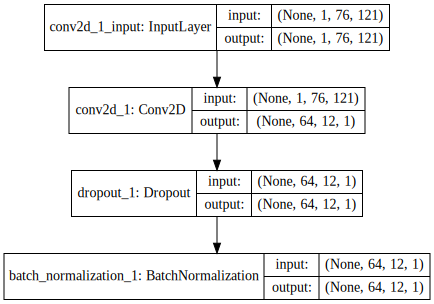

In [16]:
plot_model(base_model, show_shapes=True, to_file='base_model.png')
logger.debug("Save base_model architecture to base_model.png")
SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

__Obtain intermediate values__

Intermediate values are values directly after the base model.

In [17]:
# Obtain intermediate tensor
intermediate_a = base_model(image_a)
intermediate_b = base_model(image_b)

# Flatten the layer
flatten_a = Flatten()(intermediate_a)
flatten_b = Flatten()(intermediate_b)

__Append a layer for binary encoding__

This layer has a `tanh` activation defined in the same way as HashNet paper. Note that initial beta value, number of bits, and `alpha` in the block below are hyperparameters.

In [18]:
beta         = 1            # Initial beta value
numberOfBits = None
alpha        = 0.05         # Set to be something small because it prevents the loss function from blowing up.
logger.debug("[HashNet Model] beta = {:}, numberOfBits = {:}, alpha = {:}".format(beta, numberOfBits, alpha))

2018-03-08 00:17:39,149 - root - DEBUG - [HashNet Model] beta = 1, numberOfBits = None, alpha = 0.05


In [19]:
def custom_activation(x):
    """
    Our own defined activation function
    """
    global beta
    return K.tanh(beta * x)

In [20]:
class CustomizedLossLayer(Layer):
    """
    Our own defined layer for keeping track of loss function
    """
    
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomizedLossLayer, self).__init__(**kwargs)
    
    def my_loss(self, encoded_a, encoded_b, similarity, weight):
        global alpha
        x = encoded_a
        y = encoded_b
        dot_product = K.sum(x * y, axis=-1, keepdims=True)
        logger.debug(dot_product)
        return K.sum(weight * (K.log(1 + K.exp(alpha * dot_product)) - alpha * similarity * dot_product))
    
    def call(self, inputs):
        encoded_a = inputs[0]
        encoded_b = inputs[1]
        similarity = inputs[2]
        weight = inputs[3]
        loss = self.my_loss(encoded_a, encoded_b, similarity, weight)
        self.add_loss(loss, inputs=inputs)
        return K.ones_like(similarity)


In [21]:
activation_layer = Activation(custom_activation)
encoded_a = activation_layer(flatten_a)
encoded_b = activation_layer(flatten_b)

__Create a model for training__

We construct a model using 2 representations derived by the same base model and similarity and weight. The architecture of the model is given below.

In [22]:
# Define a loss layer with 4 inputs
loss = CustomizedLossLayer()([encoded_a, encoded_b, similarity, weight])

2018-03-08 00:17:39,212 - root - DEBUG - Tensor("customized_loss_layer_1/Sum:0", shape=(?, 1), dtype=float32)


In [23]:
# Define a model that has 4 inputs and outputs loss
model = Model(inputs=[image_a, image_b, similarity, weight], outputs=[loss])

In [24]:
# Compile the model with our own defined loss function.
# Note that loss function is already defined in a layer, so
# `zero_loss` here doesn't actually do anything.

def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

logger.debug("Use Adam optimizer with lr = 1e-5")
adam = Adam(lr=1e-5)
model.compile(optimizer=adam, loss=zero_loss)

2018-03-08 00:17:39,241 - root - DEBUG - Use Adam optimizer with lr = 1e-5


__Visualize model architecture__

2018-03-08 00:17:39,411 - root - DEBUG - Save model architecture to model.png


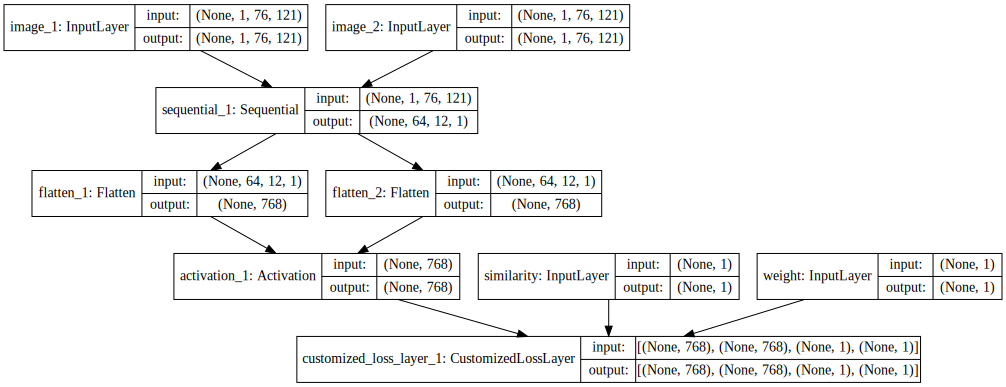

In [25]:
plot_model(model, show_shapes=True, to_file='model.png')
logger.debug("Save model architecture to model.png")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Visualize performance before training

For the purpose of understanding the performance of this algorithm, we find the baseline result by computing the hamming distance between two representations before training and then plotting the corresponding histogram. Based on the above diagram, we use the representation at layers named `flatten_1` and `flatten_2`, before the fully connected layer defined by HashNet paper.

In [26]:
representation_model = Model(image_a, flatten_a)

In [27]:
def visualize(X1, X2, groundTruth, model):
    plt.figure()
    hist_sim = []
    hist_non_sim = []
    bins = np.linspace(0, 400, 100)

    pred_X1 = (model.predict(X1) > 0)
    pred_X2 = (model.predict(X2) > 0)
    for idx in range(len(X1)):
        score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
        similarity = (groundTruth[idx][0] == groundTruth[idx][1])

        if similarity:
            hist_sim.append(score)
        else:
            hist_non_sim.append(score)

    plt.ylim((0, 135))
    plt.ylabel("Count")
    plt.xlabel("$|x-y|$, e.g. Hamming distance")
    plt.hist(hist_sim, bins, alpha=0.5, label='Similar pairs', color='blue')
    plt.hist(hist_non_sim, bins, alpha=0.5, label='Non-similar pairs', color='orange')
    plt.legend()
    plt.show()

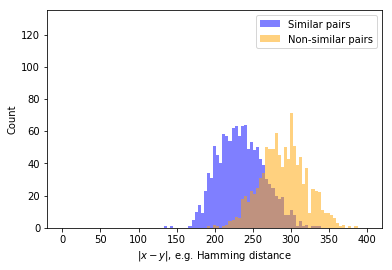

In [28]:
visualize(X1, X2, groundTruth, representation_model)

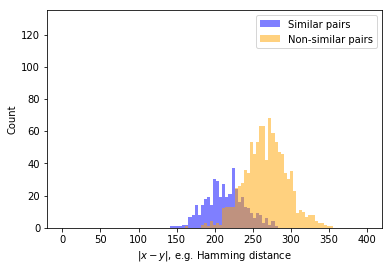

In [29]:
visualize(X1_val, X2_val, groundTruth_val, representation_model)

In [30]:
def visualizeFilters():
    nFilters = base_model.layers[0].get_weights()[0].shape[-1]
    plt.figure(figsize=(8,20))
    plt.tight_layout(pad=0, w_pad=0, h_pad=-10)
    for i in range(nFilters):
        filt = base_model.layers[0].get_weights()[0][:,:,0,i]
        plt.subplot(7, 10, i+1)
        plt.imshow(filt.T, cmap='jet')
        plt.xticks([])
        plt.yticks([])
    plt.show()

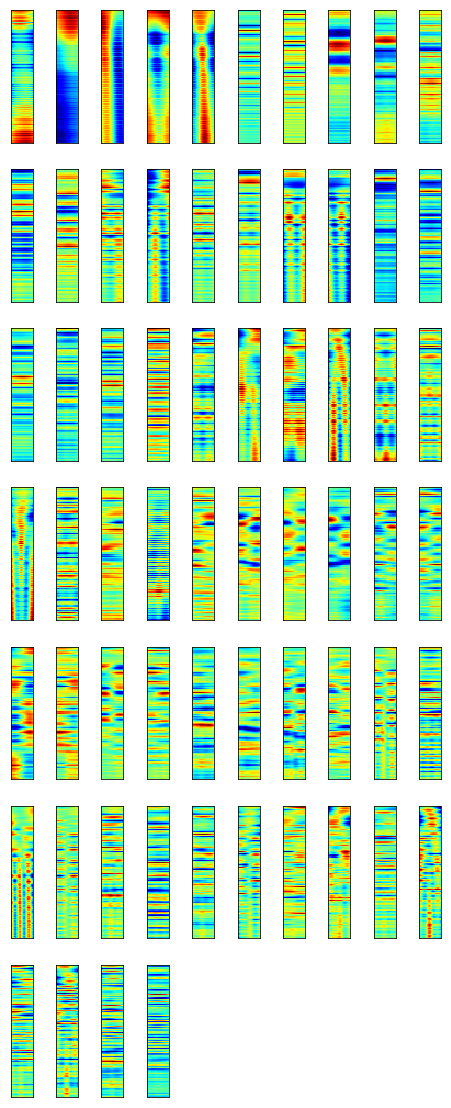

In [31]:
visualizeFilters()

## Train a model

In [32]:
# Check the input shape
logger.debug("Ready to train the model")
logger.debug("X1 shape: {:}".format(X1.shape))
logger.debug("X2 shape: {:}".format(X2.shape))
logger.debug("S shape: {:}".format(S.shape))
logger.debug("W shape: {:}".format(W.shape))

2018-03-08 00:17:44,581 - root - DEBUG - Ready to train the model
2018-03-08 00:17:44,583 - root - DEBUG - X1 shape: (2210, 1, 76, 121)
2018-03-08 00:17:44,584 - root - DEBUG - X2 shape: (2210, 1, 76, 121)
2018-03-08 00:17:44,585 - root - DEBUG - S shape: (2210, 1)
2018-03-08 00:17:44,586 - root - DEBUG - W shape: (2210, 1)


In [33]:
number_of_iterations = 100
logger.debug("[Training] number_of_iterations = {:}".format(number_of_iterations))
beta_factor = 1.5
logger.debug("[Training] beta_factor = {:}".format(beta_factor))
number_of_epochs = 200
logger.debug("[Training] number_of_epochs = {:}".format(number_of_epochs))

2018-03-08 00:17:44,601 - root - DEBUG - [Training] number_of_iterations = 100
2018-03-08 00:17:44,602 - root - DEBUG - [Training] beta_factor = 1.5
2018-03-08 00:17:44,604 - root - DEBUG - [Training] number_of_epochs = 200


In [34]:
train_losses = []
test_losses = []

2018-03-08 00:17:44,636 - root - DEBUG - Iteration 1 (current beta = 1)


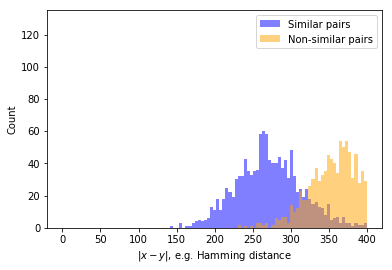

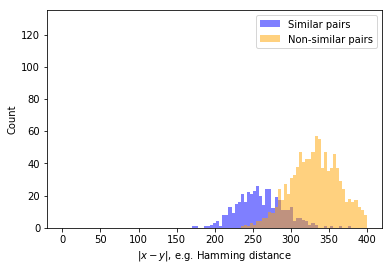

1424/1424 [==============================] - 0s 166us/step
2018-03-08 00:19:32,152 - root - DEBUG - [Iteration = 1] Training Loss = 34.182037692264196, Testing Loss = 47.34553056352594
2018-03-08 00:19:32,152 - root - DEBUG - Iteration 2 (current beta = 1.5)


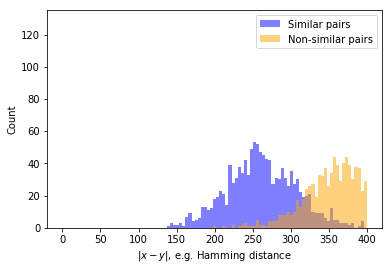

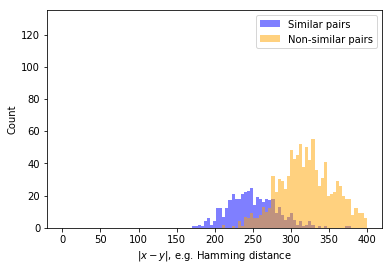

1424/1424 [==============================] - 0s 159us/step
2018-03-08 00:21:21,300 - root - DEBUG - [Iteration = 2] Training Loss = 33.77840713742631, Testing Loss = 55.28370016076592
2018-03-08 00:21:21,301 - root - DEBUG - Iteration 3 (current beta = 2.25)


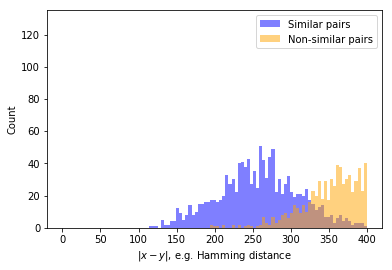

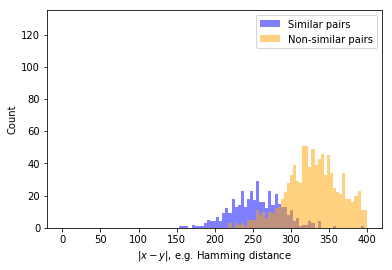

1424/1424 [==============================] - 0s 164us/step
2018-03-08 00:23:11,001 - root - DEBUG - [Iteration = 3] Training Loss = 32.80652016039887, Testing Loss = 52.32879948348142
2018-03-08 00:23:11,002 - root - DEBUG - Iteration 4 (current beta = 3.375)


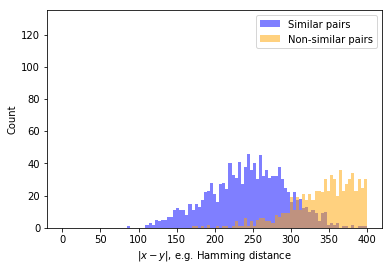

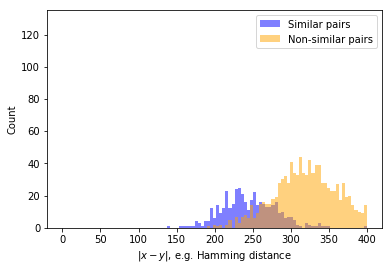

1424/1424 [==============================] - 0s 177us/step
2018-03-08 00:25:00,805 - root - DEBUG - [Iteration = 4] Training Loss = 36.374155637689306, Testing Loss = 58.33895667751184
2018-03-08 00:25:00,807 - root - DEBUG - Iteration 5 (current beta = 5.0625)


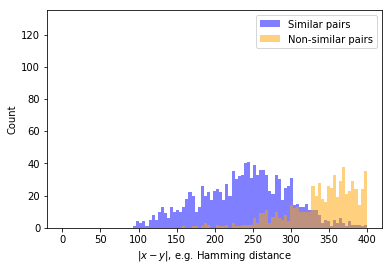

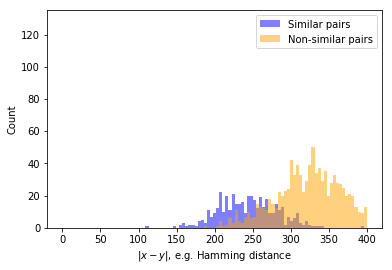

1424/1424 [==============================] - 0s 159us/step
2018-03-08 00:26:50,639 - root - DEBUG - [Iteration = 5] Training Loss = 37.13687000511998, Testing Loss = 63.39917637792866
2018-03-08 00:26:50,640 - root - DEBUG - Iteration 6 (current beta = 7.59375)


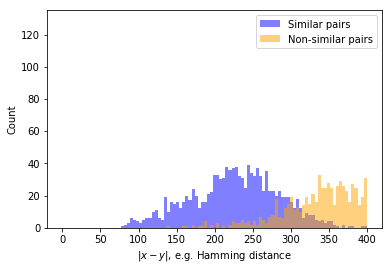

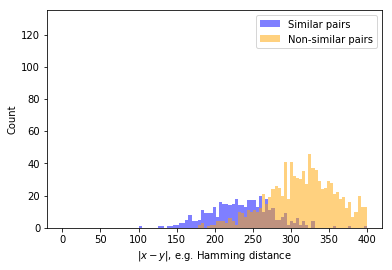

1424/1424 [==============================] - 0s 165us/step
2018-03-08 00:28:40,529 - root - DEBUG - [Iteration = 6] Training Loss = 43.162655180611765, Testing Loss = 74.59455256515675
2018-03-08 00:28:40,530 - root - DEBUG - Iteration 7 (current beta = 11.390625)


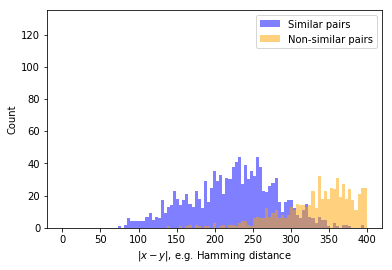

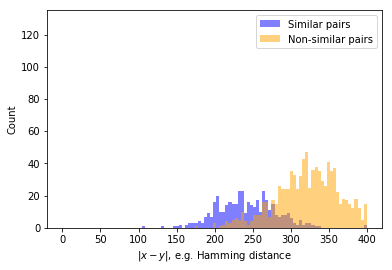

1424/1424 [==============================] - 0s 161us/step
2018-03-08 00:30:30,855 - root - DEBUG - [Iteration = 7] Training Loss = 44.202811915896056, Testing Loss = 73.53473320435941
2018-03-08 00:30:30,855 - root - DEBUG - Iteration 8 (current beta = 17.0859375)


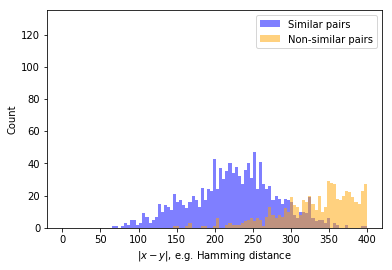

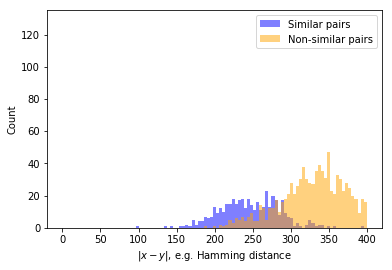

1424/1424 [==============================] - 0s 166us/step
2018-03-08 00:32:20,497 - root - DEBUG - [Iteration = 8] Training Loss = 42.85919248129987, Testing Loss = 65.83205722958854
2018-03-08 00:32:20,498 - root - DEBUG - Iteration 9 (current beta = 25.62890625)


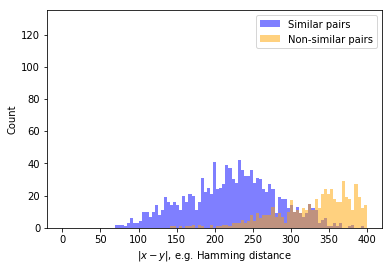

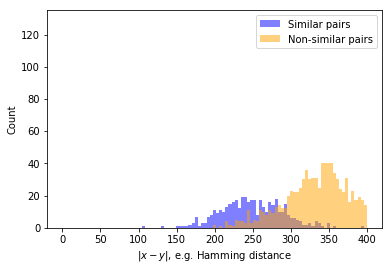

1424/1424 [==============================] - 0s 167us/step
2018-03-08 00:34:10,812 - root - DEBUG - [Iteration = 9] Training Loss = 47.52376097953158, Testing Loss = 65.63603786404214
2018-03-08 00:34:10,813 - root - DEBUG - Iteration 10 (current beta = 38.443359375)


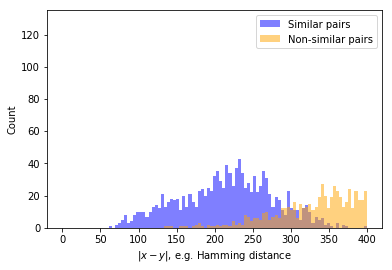

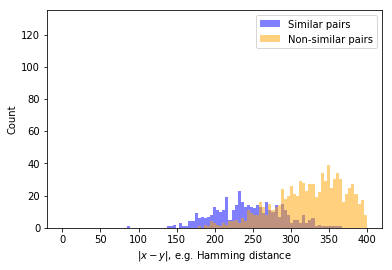

1424/1424 [==============================] - 0s 166us/step
2018-03-08 00:35:59,911 - root - DEBUG - [Iteration = 10] Training Loss = 48.86513142208168, Testing Loss = 70.59008520640684
2018-03-08 00:35:59,912 - root - DEBUG - Iteration 11 (current beta = 57.6650390625)


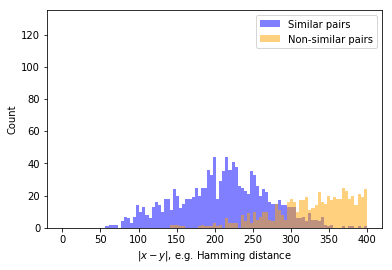

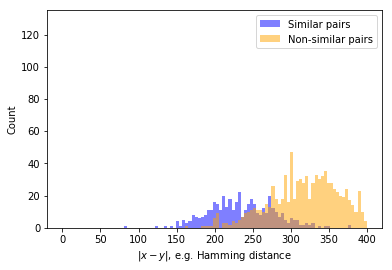

1424/1424 [==============================] - 0s 160us/step
2018-03-08 00:37:50,058 - root - DEBUG - [Iteration = 11] Training Loss = 59.186075046429266, Testing Loss = 93.87568956948398
2018-03-08 00:37:50,059 - root - DEBUG - Iteration 12 (current beta = 86.49755859375)


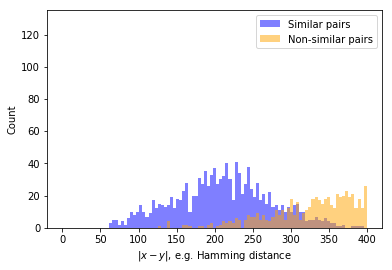

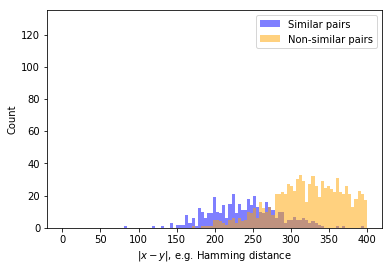

1424/1424 [==============================] - 0s 148us/step
2018-03-08 00:39:39,698 - root - DEBUG - [Iteration = 12] Training Loss = 56.1821624427427, Testing Loss = 87.69896629452705
2018-03-08 00:39:39,699 - root - DEBUG - Iteration 13 (current beta = 129.746337890625)


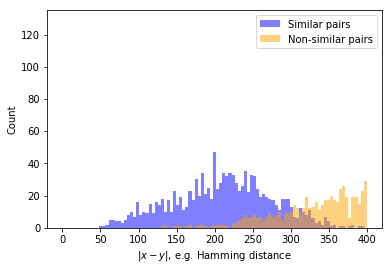

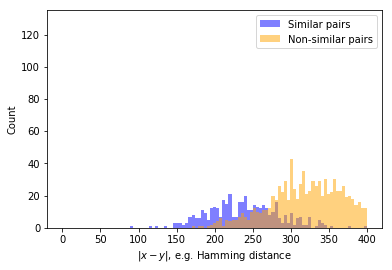

1424/1424 [==============================] - 0s 169us/step
2018-03-08 00:41:29,452 - root - DEBUG - [Iteration = 13] Training Loss = 58.695435565447106, Testing Loss = 96.14952057733964
2018-03-08 00:41:29,454 - root - DEBUG - Iteration 14 (current beta = 194.6195068359375)


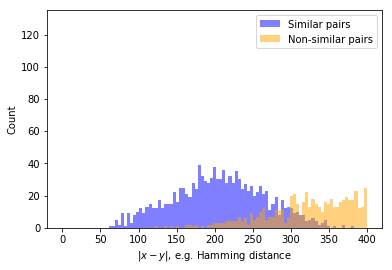

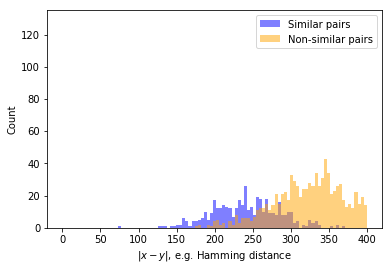

1424/1424 [==============================] - 0s 176us/step
2018-03-08 00:43:25,755 - root - DEBUG - [Iteration = 14] Training Loss = 60.85496080490124, Testing Loss = 81.48156606146459
2018-03-08 00:43:25,757 - root - DEBUG - Iteration 15 (current beta = 291.92926025390625)


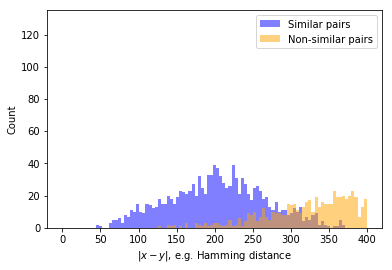

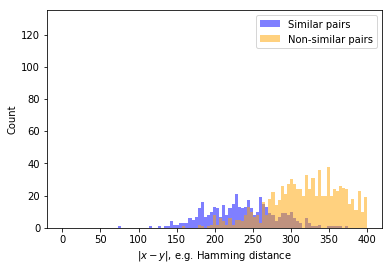

1424/1424 [==============================] - 0s 157us/step
2018-03-08 00:45:19,735 - root - DEBUG - [Iteration = 15] Training Loss = 62.40482155410615, Testing Loss = 88.48584075925055
2018-03-08 00:45:19,736 - root - DEBUG - Iteration 16 (current beta = 437.8938903808594)


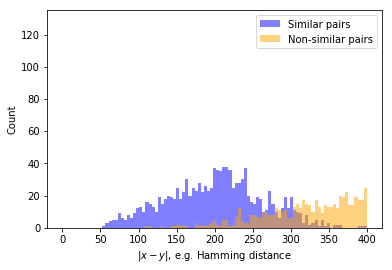

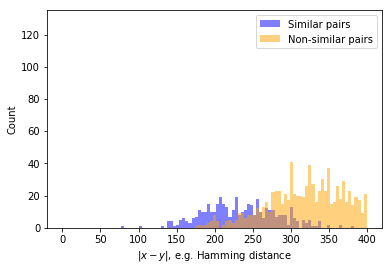

1424/1424 [==============================] - 0s 170us/step
2018-03-08 00:47:10,300 - root - DEBUG - [Iteration = 16] Training Loss = 68.72498128298687, Testing Loss = 97.93579640088791
2018-03-08 00:47:10,301 - root - DEBUG - Iteration 17 (current beta = 656.8408355712891)


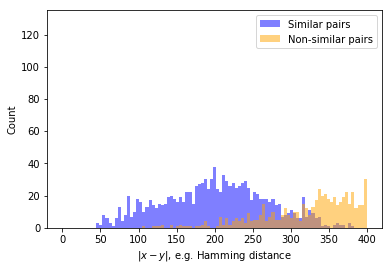

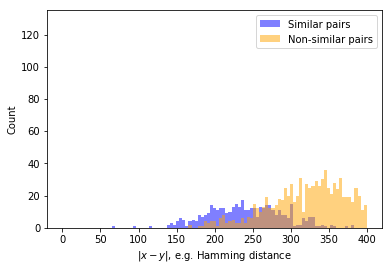

1424/1424 [==============================] - 0s 165us/step
2018-03-08 00:49:00,636 - root - DEBUG - [Iteration = 17] Training Loss = 62.94605432736321, Testing Loss = 88.27934098310685
2018-03-08 00:49:00,636 - root - DEBUG - Iteration 18 (current beta = 985.2612533569336)


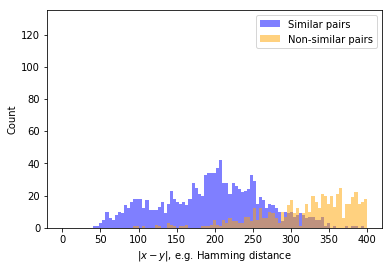

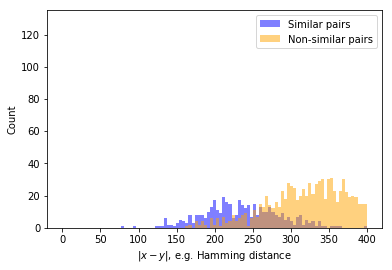

1424/1424 [==============================] - 0s 163us/step
2018-03-08 00:50:52,169 - root - DEBUG - [Iteration = 18] Training Loss = 65.69316189767481, Testing Loss = 91.22428983952223
2018-03-08 00:50:52,170 - root - DEBUG - Iteration 19 (current beta = 1477.8918800354004)


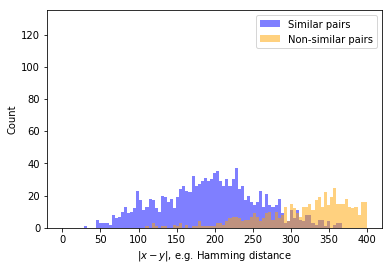

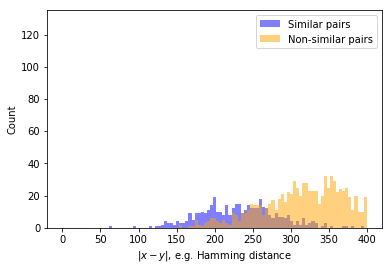

1424/1424 [==============================] - 0s 169us/step
2018-03-08 00:52:42,661 - root - DEBUG - [Iteration = 19] Training Loss = 66.17860369121833, Testing Loss = 103.351414143202
2018-03-08 00:52:42,662 - root - DEBUG - Iteration 20 (current beta = 2216.8378200531006)


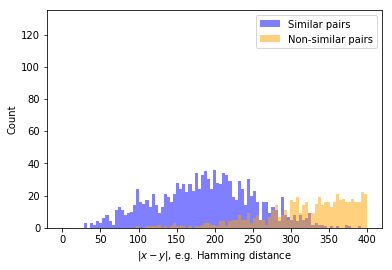

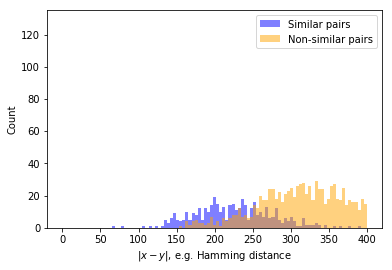

1424/1424 [==============================] - 0s 169us/step
2018-03-08 00:54:33,792 - root - DEBUG - [Iteration = 20] Training Loss = 75.47310670536956, Testing Loss = 119.41260269223555
2018-03-08 00:54:33,793 - root - DEBUG - Iteration 21 (current beta = 3325.256730079651)


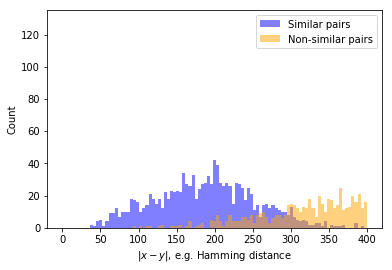

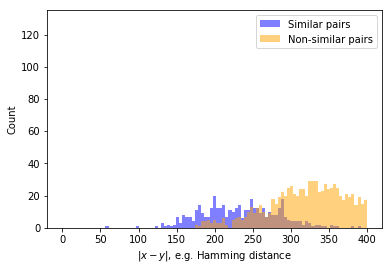

1424/1424 [==============================] - 0s 179us/step
2018-03-08 00:56:22,984 - root - DEBUG - [Iteration = 21] Training Loss = 76.24415313450334, Testing Loss = 101.06870329030528
2018-03-08 00:56:22,985 - root - DEBUG - Iteration 22 (current beta = 4987.885095119476)


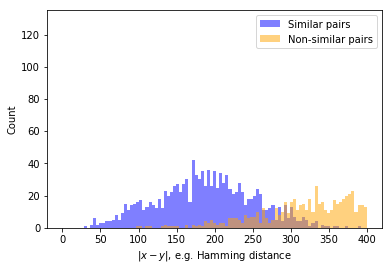

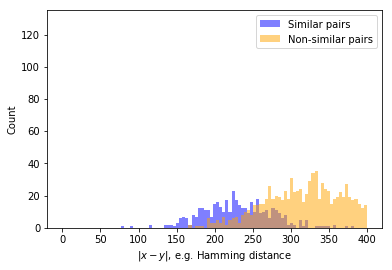

1424/1424 [==============================] - 0s 164us/step
2018-03-08 00:58:13,217 - root - DEBUG - [Iteration = 22] Training Loss = 79.83610194312973, Testing Loss = 110.60638707717148
2018-03-08 00:58:13,219 - root - DEBUG - Iteration 23 (current beta = 7481.8276426792145)


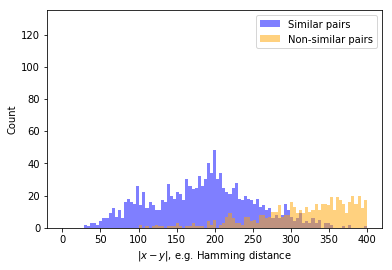

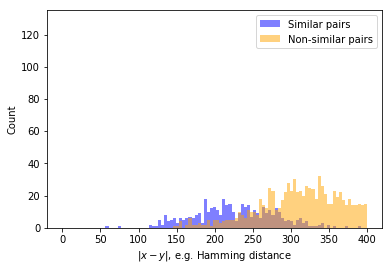

1424/1424 [==============================] - 0s 155us/step
2018-03-08 01:00:02,950 - root - DEBUG - [Iteration = 23] Training Loss = 75.23467559431094, Testing Loss = 116.46595778454387
2018-03-08 01:00:02,951 - root - DEBUG - Iteration 24 (current beta = 11222.741464018822)


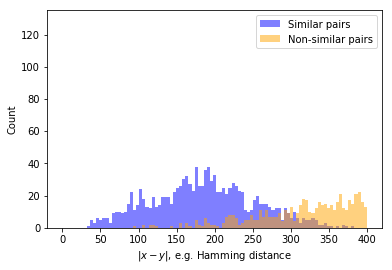

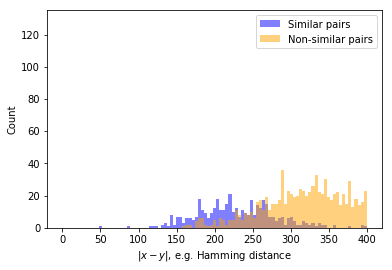

1424/1424 [==============================] - 0s 159us/step
2018-03-08 01:01:53,614 - root - DEBUG - [Iteration = 24] Training Loss = 76.04896878014146, Testing Loss = 110.51576863597619
2018-03-08 01:01:53,615 - root - DEBUG - Iteration 25 (current beta = 16834.112196028233)


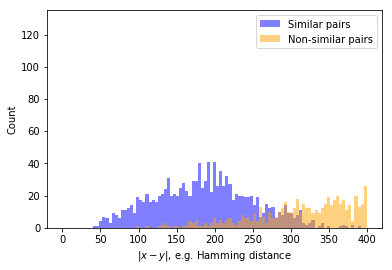

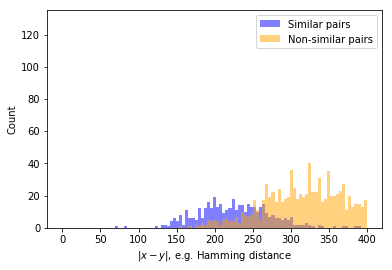

1424/1424 [==============================] - 0s 170us/step
2018-03-08 01:03:42,565 - root - DEBUG - [Iteration = 25] Training Loss = 82.08875894677821, Testing Loss = 111.16015253467171
2018-03-08 01:03:42,566 - root - DEBUG - Iteration 26 (current beta = 25251.16829404235)


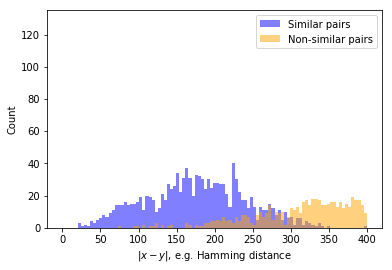

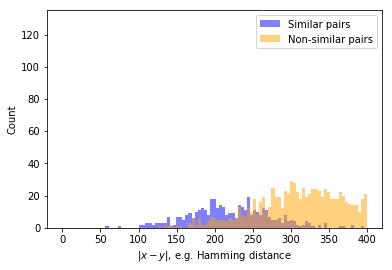

1424/1424 [==============================] - 0s 168us/step
2018-03-08 01:05:34,194 - root - DEBUG - [Iteration = 26] Training Loss = 78.95644861768501, Testing Loss = 109.4434011861096
2018-03-08 01:05:34,196 - root - DEBUG - Iteration 27 (current beta = 37876.75244106352)


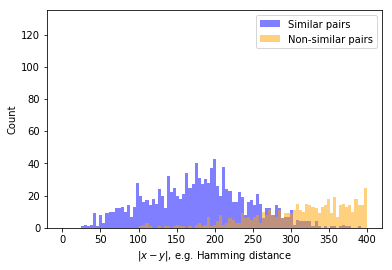

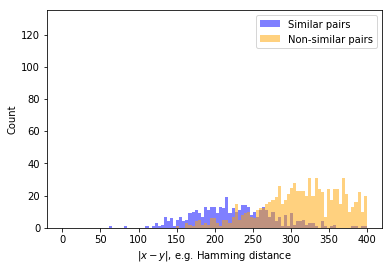

1424/1424 [==============================] - 0s 166us/step
2018-03-08 01:07:27,314 - root - DEBUG - [Iteration = 27] Training Loss = 79.24929535402643, Testing Loss = 112.78493480685722
2018-03-08 01:07:27,315 - root - DEBUG - Iteration 28 (current beta = 56815.128661595285)


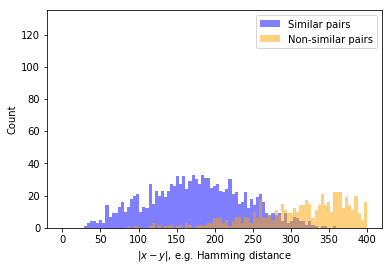

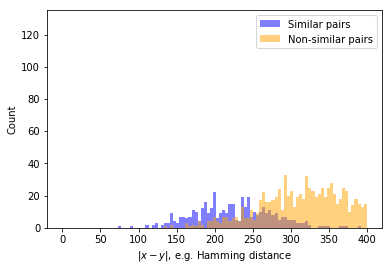

1424/1424 [==============================] - 0s 200us/step
2018-03-08 01:09:31,589 - root - DEBUG - [Iteration = 28] Training Loss = 81.4601553973055, Testing Loss = 101.27056541457102
2018-03-08 01:09:31,591 - root - DEBUG - Iteration 29 (current beta = 85222.69299239293)


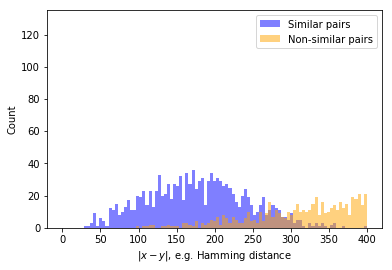

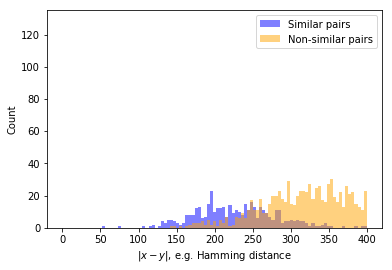

1424/1424 [==============================] - 0s 180us/step
2018-03-08 01:11:35,377 - root - DEBUG - [Iteration = 29] Training Loss = 79.46873375512575, Testing Loss = 103.29886158631089
2018-03-08 01:11:35,378 - root - DEBUG - Iteration 30 (current beta = 127834.03948858939)


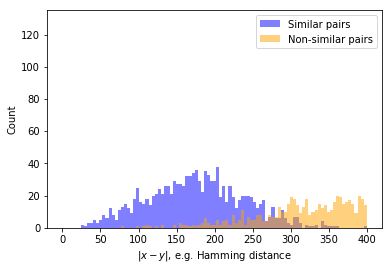

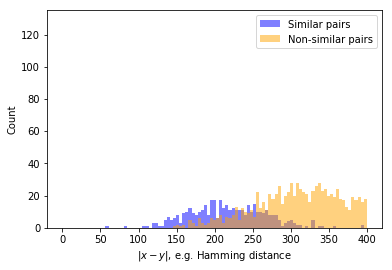

1424/1424 [==============================] - 0s 184us/step
2018-03-08 01:13:38,944 - root - DEBUG - [Iteration = 30] Training Loss = 87.51485696555962, Testing Loss = 131.77910413679908
2018-03-08 01:13:38,946 - root - DEBUG - Iteration 31 (current beta = 191751.0592328841)


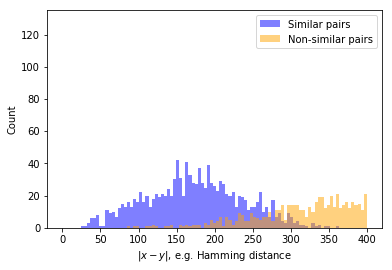

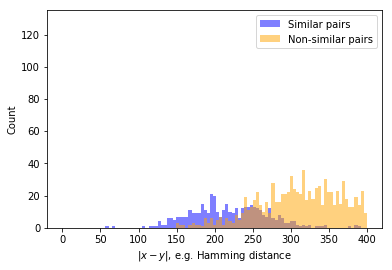

1424/1424 [==============================] - 0s 164us/step
2018-03-08 01:15:42,302 - root - DEBUG - [Iteration = 31] Training Loss = 81.95119458136267, Testing Loss = 117.50830979055065
2018-03-08 01:15:42,303 - root - DEBUG - Iteration 32 (current beta = 287626.58884932613)


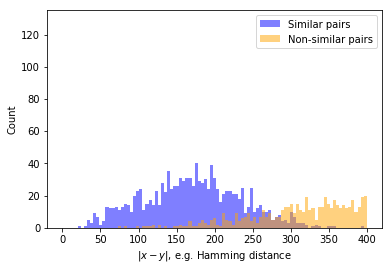

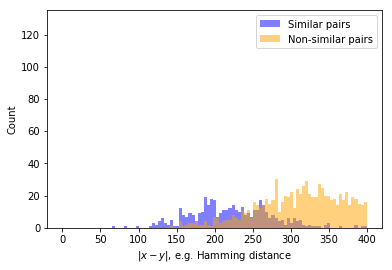

1424/1424 [==============================] - 0s 192us/step
2018-03-08 01:17:47,430 - root - DEBUG - [Iteration = 32] Training Loss = 83.7841005210082, Testing Loss = 107.18211203269409
2018-03-08 01:17:47,431 - root - DEBUG - Iteration 33 (current beta = 431439.8832739892)


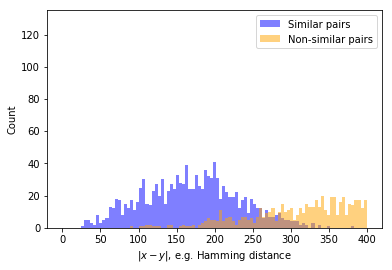

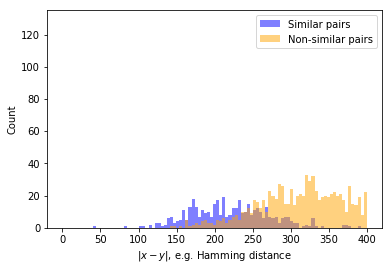

1424/1424 [==============================] - 0s 181us/step
2018-03-08 01:19:50,429 - root - DEBUG - [Iteration = 33] Training Loss = 88.1490559226079, Testing Loss = 115.07778695991702
2018-03-08 01:19:50,430 - root - DEBUG - Iteration 34 (current beta = 647159.8249109838)


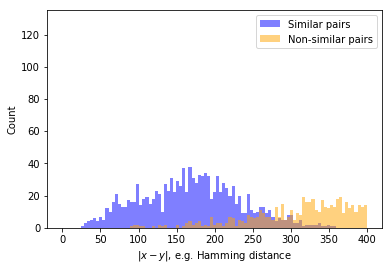

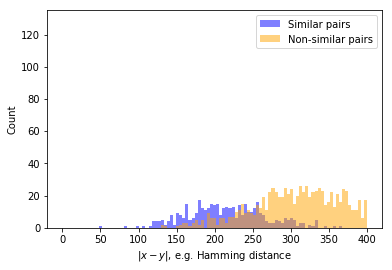

1424/1424 [==============================] - 0s 187us/step
2018-03-08 01:21:53,431 - root - DEBUG - [Iteration = 34] Training Loss = 81.36307529196695, Testing Loss = 121.8794697417637
2018-03-08 01:21:53,433 - root - DEBUG - Iteration 35 (current beta = 970739.7373664756)


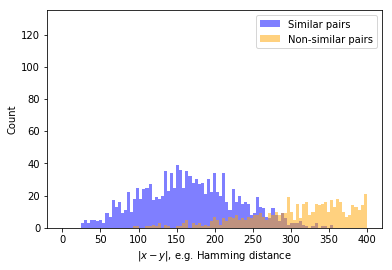

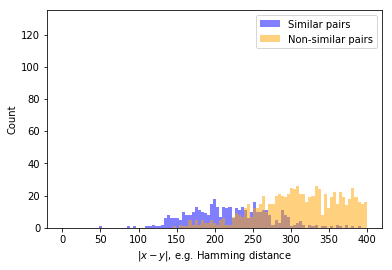

1424/1424 [==============================] - 0s 174us/step
2018-03-08 01:23:55,256 - root - DEBUG - [Iteration = 35] Training Loss = 91.41005315853471, Testing Loss = 116.6667846715329
2018-03-08 01:23:55,257 - root - DEBUG - Iteration 36 (current beta = 1456109.6060497134)


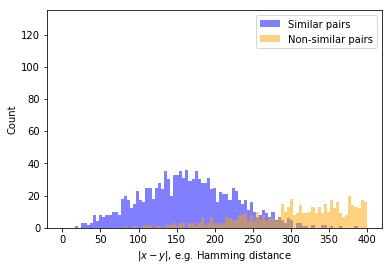

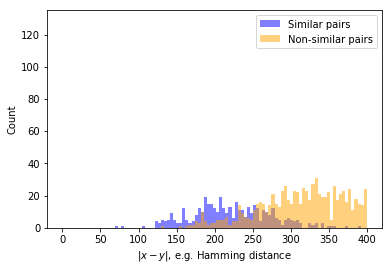

1424/1424 [==============================] - 0s 190us/step
2018-03-08 01:25:59,055 - root - DEBUG - [Iteration = 36] Training Loss = 89.05720092445492, Testing Loss = 113.31868171795492
2018-03-08 01:25:59,056 - root - DEBUG - Iteration 37 (current beta = 2184164.40907457)


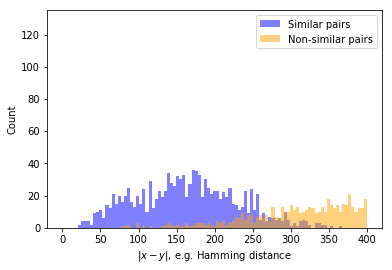

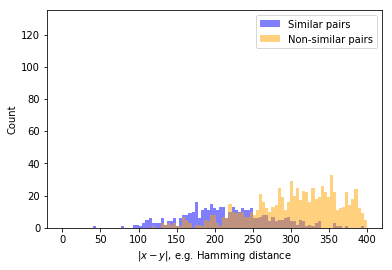

1424/1424 [==============================] - 0s 181us/step
2018-03-08 01:28:01,548 - root - DEBUG - [Iteration = 37] Training Loss = 87.99378683963502, Testing Loss = 133.32414527298107
2018-03-08 01:28:01,550 - root - DEBUG - Iteration 38 (current beta = 3276246.613611855)


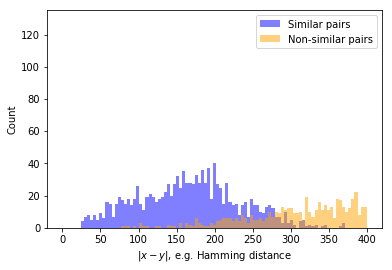

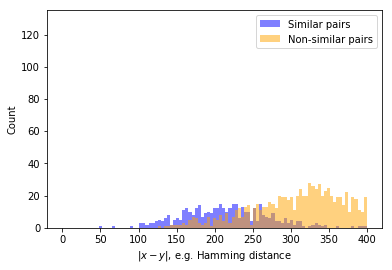

1424/1424 [==============================] - 0s 183us/step
2018-03-08 01:30:06,505 - root - DEBUG - [Iteration = 38] Training Loss = 87.08915894102059, Testing Loss = 125.48726692301838
2018-03-08 01:30:06,506 - root - DEBUG - Iteration 39 (current beta = 4914369.920417783)


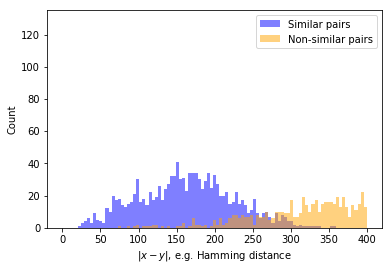

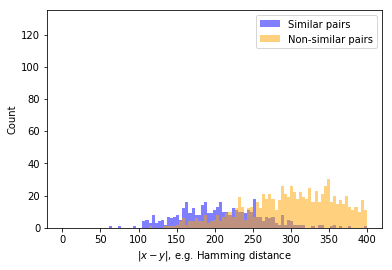

1424/1424 [==============================] - 0s 189us/step
2018-03-08 01:32:08,423 - root - DEBUG - [Iteration = 39] Training Loss = 87.679232954987, Testing Loss = 127.7591703724158
2018-03-08 01:32:08,424 - root - DEBUG - Iteration 40 (current beta = 7371554.880626675)


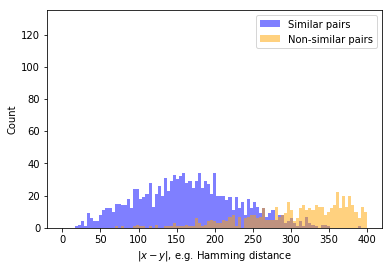

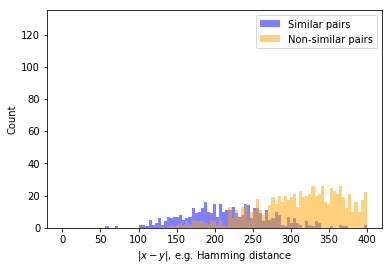

1424/1424 [==============================] - 0s 177us/step
2018-03-08 01:34:11,837 - root - DEBUG - [Iteration = 40] Training Loss = 89.7763531459281, Testing Loss = 117.399184953233
2018-03-08 01:34:11,838 - root - DEBUG - Iteration 41 (current beta = 11057332.320940012)


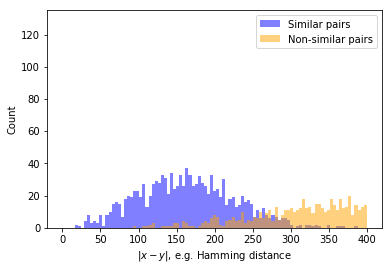

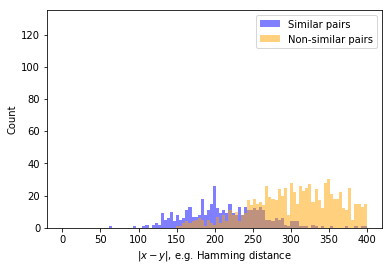

1424/1424 [==============================] - 0s 182us/step
2018-03-08 01:36:14,596 - root - DEBUG - [Iteration = 41] Training Loss = 94.10356967246399, Testing Loss = 134.10759708463226
2018-03-08 01:36:14,598 - root - DEBUG - Iteration 42 (current beta = 16585998.48141002)


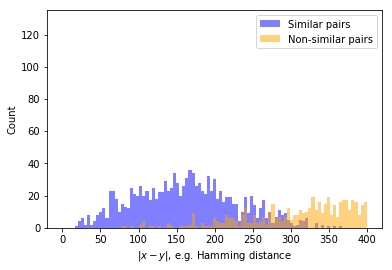

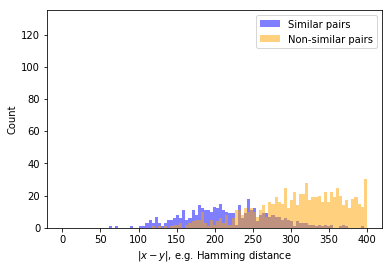

1424/1424 [==============================] - 0s 189us/step
2018-03-08 01:38:18,720 - root - DEBUG - [Iteration = 42] Training Loss = 79.79750291051904, Testing Loss = 109.1046399513699
2018-03-08 01:38:18,721 - root - DEBUG - Iteration 43 (current beta = 24878997.72211503)


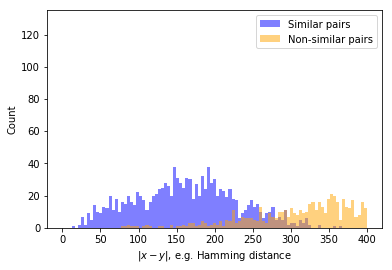

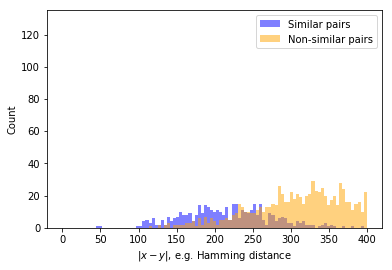

1424/1424 [==============================] - 0s 175us/step
2018-03-08 01:40:20,939 - root - DEBUG - [Iteration = 43] Training Loss = 81.81797094766874, Testing Loss = 117.75138509842787
2018-03-08 01:40:20,940 - root - DEBUG - Iteration 44 (current beta = 37318496.583172545)


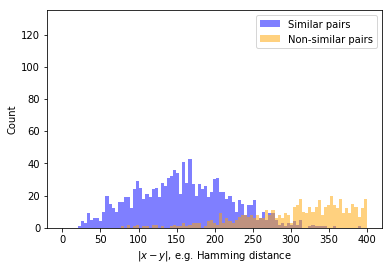

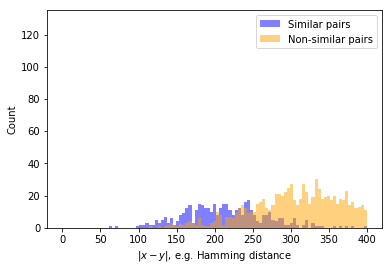

1424/1424 [==============================] - 0s 196us/step
2018-03-08 01:42:25,033 - root - DEBUG - [Iteration = 44] Training Loss = 88.3594873030524, Testing Loss = 122.27641490165647
2018-03-08 01:42:25,034 - root - DEBUG - Iteration 45 (current beta = 55977744.87475882)


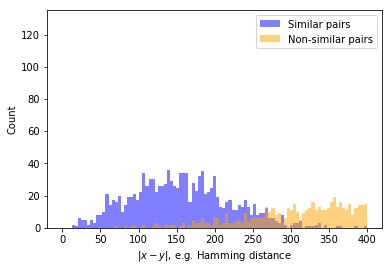

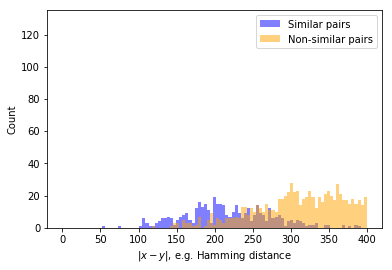

1424/1424 [==============================] - 0s 194us/step
2018-03-08 01:44:27,616 - root - DEBUG - [Iteration = 45] Training Loss = 93.02389079917941, Testing Loss = 120.68653785598495
2018-03-08 01:44:27,617 - root - DEBUG - Iteration 46 (current beta = 83966617.31213823)


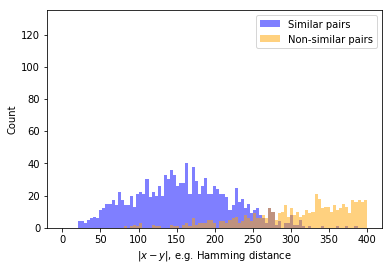

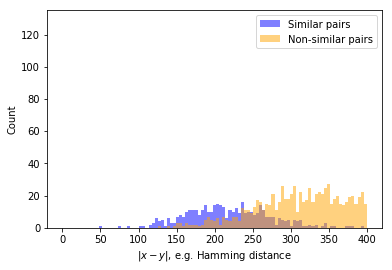

1424/1424 [==============================] - 0s 186us/step
2018-03-08 01:46:31,861 - root - DEBUG - [Iteration = 46] Training Loss = 87.18806154165281, Testing Loss = 110.1948931844633
2018-03-08 01:46:31,863 - root - DEBUG - Iteration 47 (current beta = 125949925.96820734)


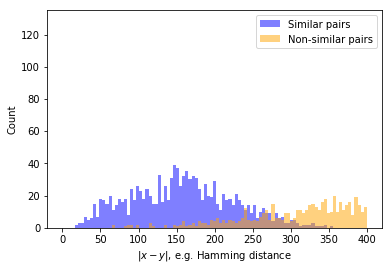

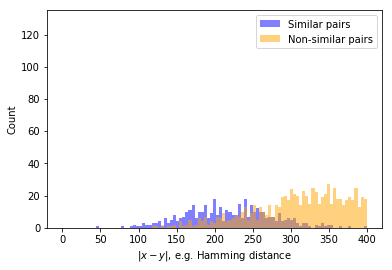

1424/1424 [==============================] - 0s 185us/step
2018-03-08 01:48:33,420 - root - DEBUG - [Iteration = 47] Training Loss = 85.50124210333514, Testing Loss = 107.97646604202102
2018-03-08 01:48:33,421 - root - DEBUG - Iteration 48 (current beta = 188924888.952311)


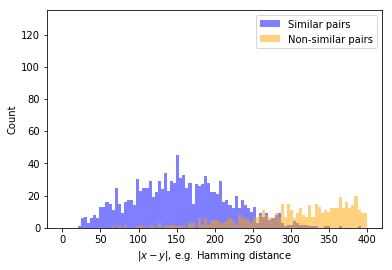

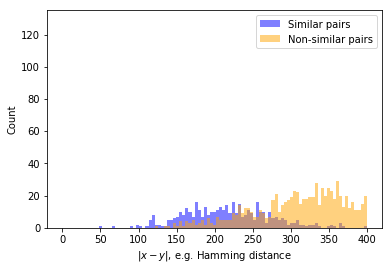

1424/1424 [==============================] - 0s 178us/step
2018-03-08 01:50:37,916 - root - DEBUG - [Iteration = 48] Training Loss = 89.91392438671123, Testing Loss = 114.56426610789272
2018-03-08 01:50:37,918 - root - DEBUG - Iteration 49 (current beta = 283387333.4284665)


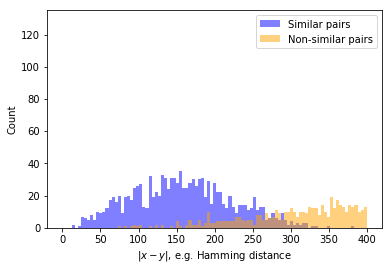

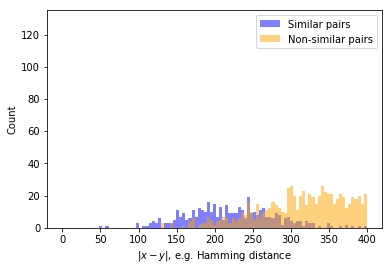

1424/1424 [==============================] - 0s 175us/step
2018-03-08 01:52:40,022 - root - DEBUG - [Iteration = 49] Training Loss = 84.56193977851348, Testing Loss = 98.8696754378884
2018-03-08 01:52:40,023 - root - DEBUG - Iteration 50 (current beta = 425081000.1426997)


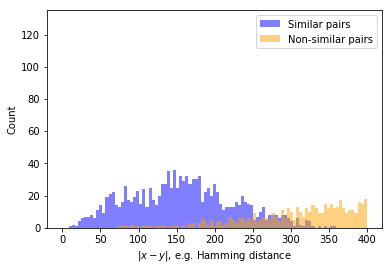

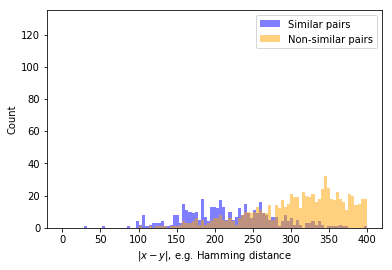

1424/1424 [==============================] - 0s 197us/step
2018-03-08 01:54:42,851 - root - DEBUG - [Iteration = 50] Training Loss = 80.78071023166146, Testing Loss = 105.20716438308526
2018-03-08 01:54:42,852 - root - DEBUG - Iteration 51 (current beta = 637621500.2140496)


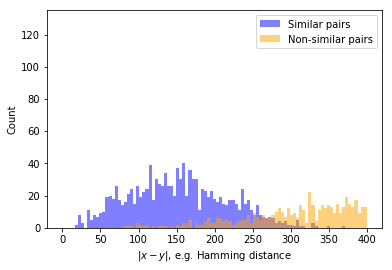

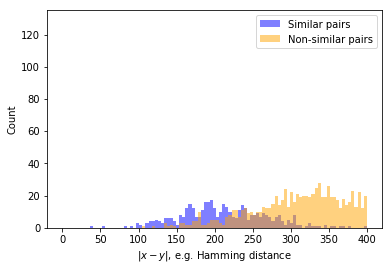

1424/1424 [==============================] - 0s 210us/step
2018-03-08 01:56:43,643 - root - DEBUG - [Iteration = 51] Training Loss = 92.44148764197669, Testing Loss = 124.12358029049643
2018-03-08 01:56:43,644 - root - DEBUG - Iteration 52 (current beta = 956432250.3210744)


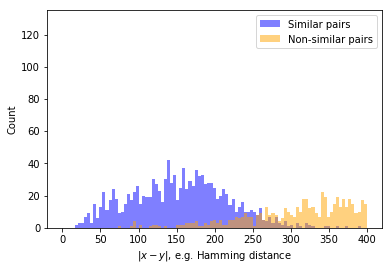

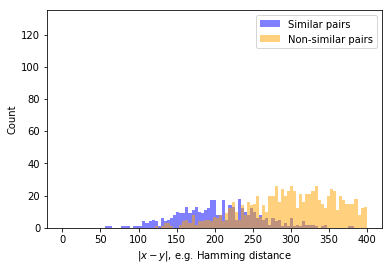

1424/1424 [==============================] - 0s 181us/step
2018-03-08 01:58:47,933 - root - DEBUG - [Iteration = 52] Training Loss = 92.93296934829422, Testing Loss = 136.39975568044179
2018-03-08 01:58:47,934 - root - DEBUG - Iteration 53 (current beta = 1434648375.4816115)


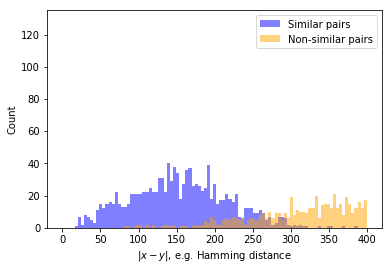

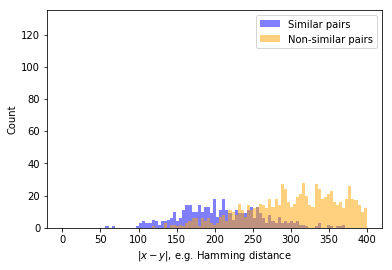

1424/1424 [==============================] - 0s 188us/step
2018-03-08 02:00:49,236 - root - DEBUG - [Iteration = 53] Training Loss = 88.07110215065065, Testing Loss = 120.08005431112362
2018-03-08 02:00:49,237 - root - DEBUG - Iteration 54 (current beta = 2151972563.2224174)


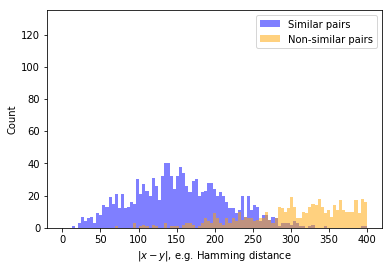

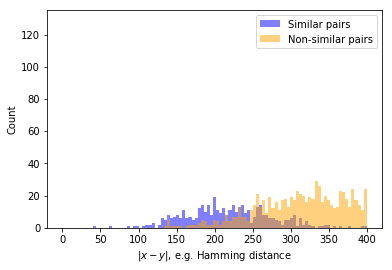

1424/1424 [==============================] - 0s 183us/step
2018-03-08 02:02:53,755 - root - DEBUG - [Iteration = 54] Training Loss = 89.90149169848148, Testing Loss = 105.12242813912754
2018-03-08 02:02:53,756 - root - DEBUG - Iteration 55 (current beta = 3227958844.833626)


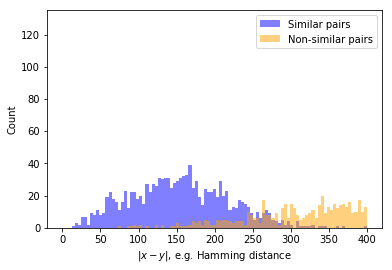

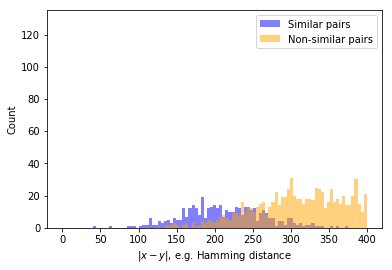

1424/1424 [==============================] - 0s 185us/step
2018-03-08 02:04:55,700 - root - DEBUG - [Iteration = 55] Training Loss = 86.31155356400119, Testing Loss = 118.47429613624647
2018-03-08 02:04:55,701 - root - DEBUG - Iteration 56 (current beta = 4841938267.250439)


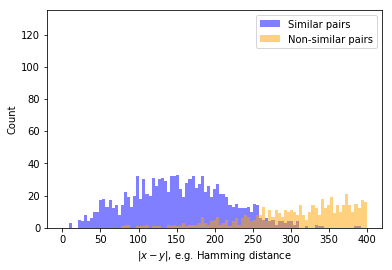

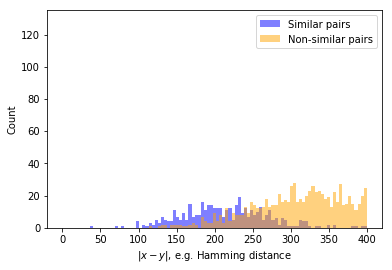

1424/1424 [==============================] - 0s 172us/step
2018-03-08 02:06:58,543 - root - DEBUG - [Iteration = 56] Training Loss = 91.19405398957115, Testing Loss = 120.1352764134494
2018-03-08 02:06:58,545 - root - DEBUG - Iteration 57 (current beta = 7262907400.875658)


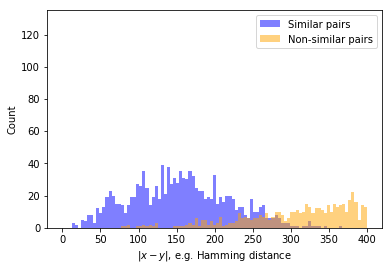

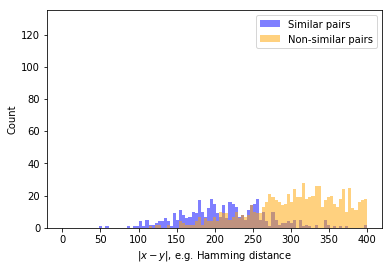

1424/1424 [==============================] - 0s 187us/step
2018-03-08 02:09:01,023 - root - DEBUG - [Iteration = 57] Training Loss = 86.63638611102441, Testing Loss = 118.30459555560786
2018-03-08 02:09:01,024 - root - DEBUG - Iteration 58 (current beta = 10894361101.313488)


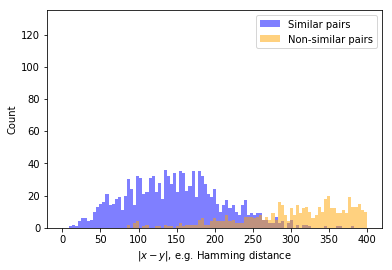

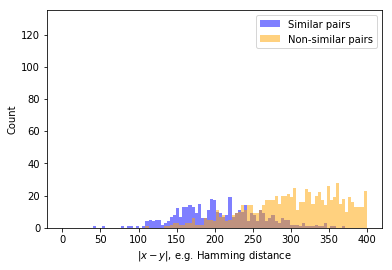

1424/1424 [==============================] - 0s 182us/step
2018-03-08 02:11:05,729 - root - DEBUG - [Iteration = 58] Training Loss = 96.75171729874106, Testing Loss = 132.3591623229859
2018-03-08 02:11:05,730 - root - DEBUG - Iteration 59 (current beta = 16341541651.970232)


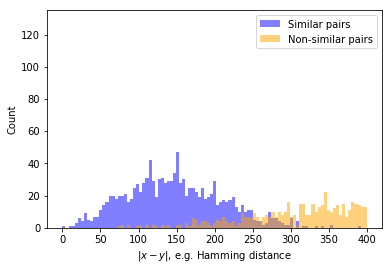

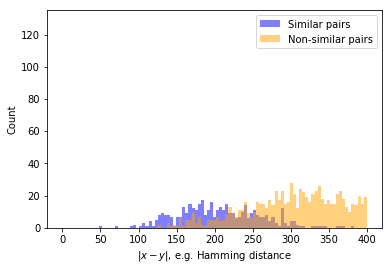

1424/1424 [==============================] - 0s 179us/step
2018-03-08 02:13:08,209 - root - DEBUG - [Iteration = 59] Training Loss = 97.5581279379992, Testing Loss = 138.79473916920205
2018-03-08 02:13:08,210 - root - DEBUG - Iteration 60 (current beta = 24512312477.95535)


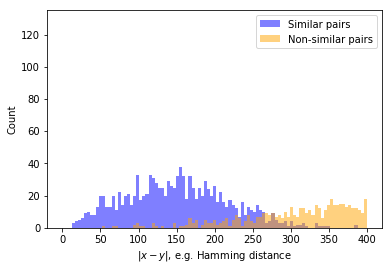

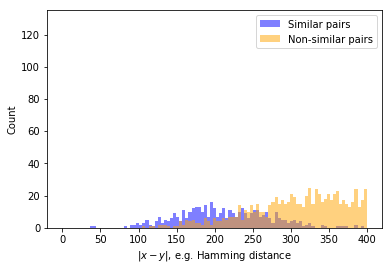

1424/1424 [==============================] - 0s 181us/step
2018-03-08 02:15:11,134 - root - DEBUG - [Iteration = 60] Training Loss = 86.23918987377935, Testing Loss = 112.4830494738613
2018-03-08 02:15:11,135 - root - DEBUG - Iteration 61 (current beta = 36768468716.93302)


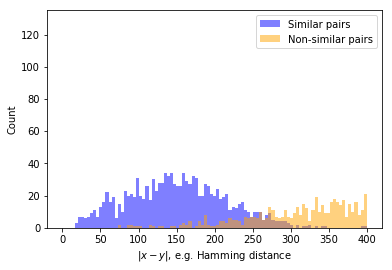

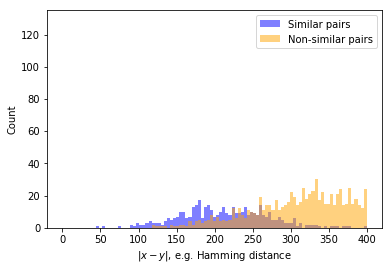

1424/1424 [==============================] - 0s 183us/step
2018-03-08 02:17:12,424 - root - DEBUG - [Iteration = 61] Training Loss = 88.39282081909803, Testing Loss = 113.37036308449473
2018-03-08 02:17:12,425 - root - DEBUG - Iteration 62 (current beta = 55152703075.399536)


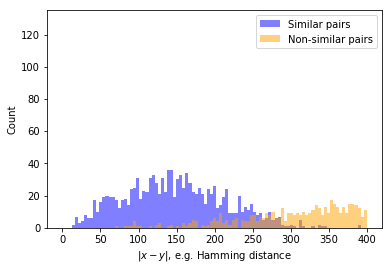

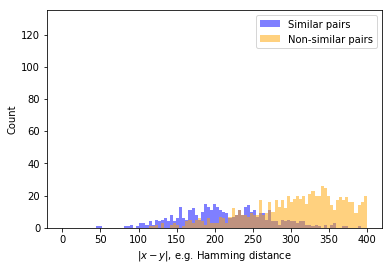

1424/1424 [==============================] - 0s 181us/step
2018-03-08 02:19:15,039 - root - DEBUG - [Iteration = 62] Training Loss = 84.84353061655831, Testing Loss = 112.12664641144822
2018-03-08 02:19:15,040 - root - DEBUG - Iteration 63 (current beta = 82729054613.0993)


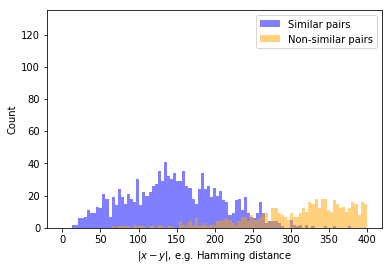

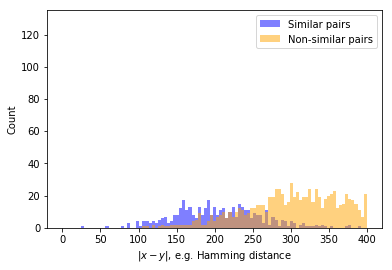

1424/1424 [==============================] - 0s 186us/step
2018-03-08 02:21:16,284 - root - DEBUG - [Iteration = 63] Training Loss = 91.36644294791603, Testing Loss = 134.32500366194782
2018-03-08 02:21:16,285 - root - DEBUG - Iteration 64 (current beta = 124093581919.64896)


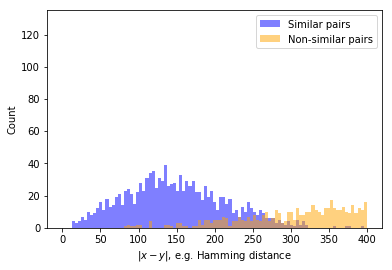

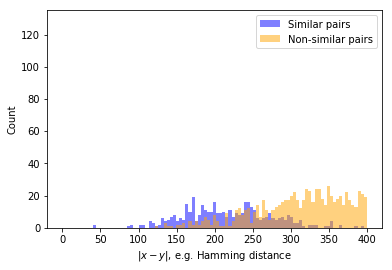

1424/1424 [==============================] - 0s 186us/step
2018-03-08 02:23:19,563 - root - DEBUG - [Iteration = 64] Training Loss = 90.10521016231858, Testing Loss = 116.48807062951094
2018-03-08 02:23:19,564 - root - DEBUG - Iteration 65 (current beta = 186140372879.47345)


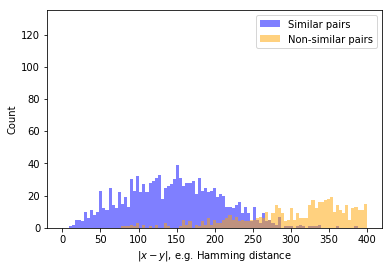

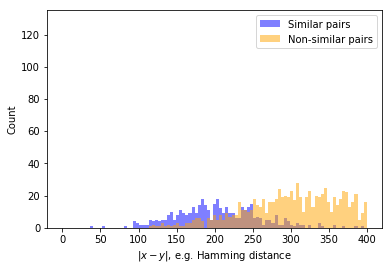

1424/1424 [==============================] - 0s 188us/step
2018-03-08 02:25:20,679 - root - DEBUG - [Iteration = 65] Training Loss = 91.45582959349635, Testing Loss = 132.47429139578318
2018-03-08 02:25:20,681 - root - DEBUG - Iteration 66 (current beta = 279210559319.2102)


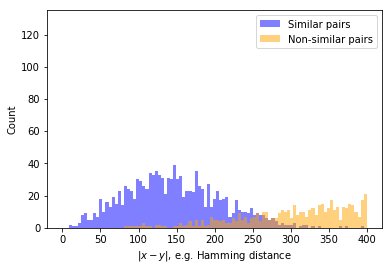

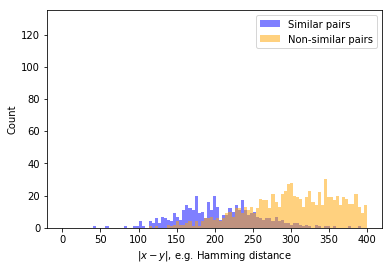

1424/1424 [==============================] - 0s 178us/step
2018-03-08 02:27:24,406 - root - DEBUG - [Iteration = 66] Training Loss = 97.37280144884758, Testing Loss = 139.87981544302912
2018-03-08 02:27:24,408 - root - DEBUG - Iteration 67 (current beta = 418815838978.8153)


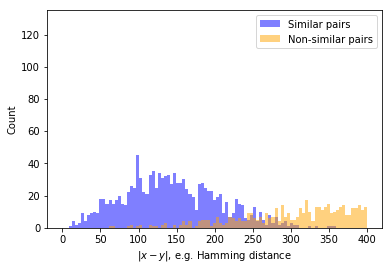

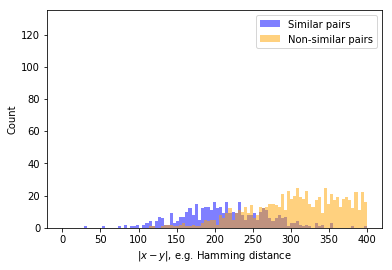

1424/1424 [==============================] - 0s 198us/step
2018-03-08 02:29:26,424 - root - DEBUG - [Iteration = 67] Training Loss = 93.62381634288757, Testing Loss = 120.61982087348326
2018-03-08 02:29:26,425 - root - DEBUG - Iteration 68 (current beta = 628223758468.2229)


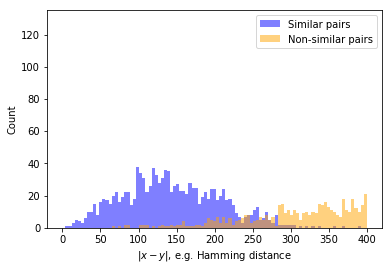

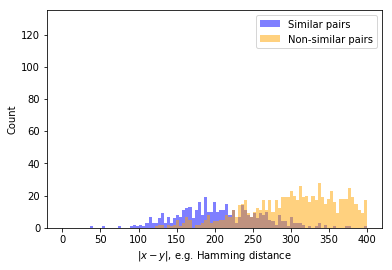

1424/1424 [==============================] - 0s 198us/step
2018-03-08 02:31:30,984 - root - DEBUG - [Iteration = 68] Training Loss = 94.58134521405871, Testing Loss = 133.2543724264918
2018-03-08 02:31:30,986 - root - DEBUG - Iteration 69 (current beta = 942335637702.3344)


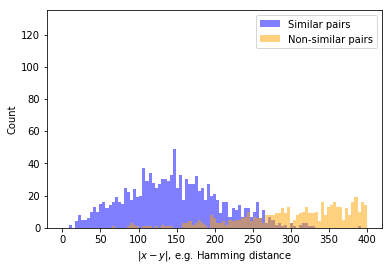

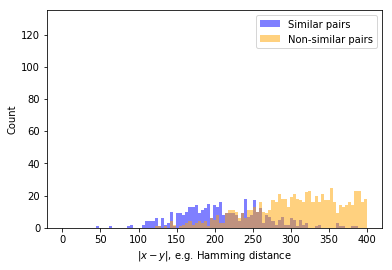

1424/1424 [==============================] - 0s 175us/step
2018-03-08 02:33:33,804 - root - DEBUG - [Iteration = 69] Training Loss = 88.68833443439513, Testing Loss = 112.76025917906355
2018-03-08 02:33:33,805 - root - DEBUG - Iteration 70 (current beta = 1413503456553.5015)


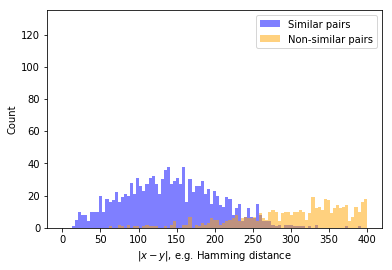

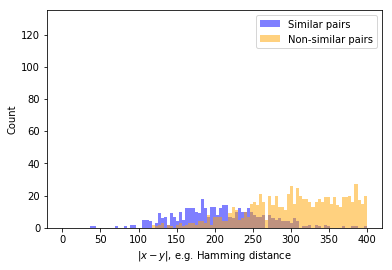

1424/1424 [==============================] - 0s 188us/step
2018-03-08 02:35:38,065 - root - DEBUG - [Iteration = 70] Training Loss = 93.00960200089204, Testing Loss = 121.2754908918581
2018-03-08 02:35:38,066 - root - DEBUG - Iteration 71 (current beta = 2120255184830.2522)


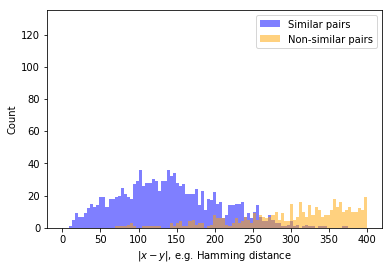

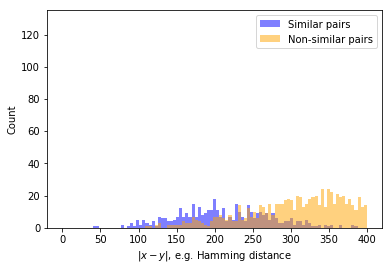

1424/1424 [==============================] - 0s 181us/step
2018-03-08 02:37:40,812 - root - DEBUG - [Iteration = 71] Training Loss = 92.05197122519867, Testing Loss = 117.02402071547014
2018-03-08 02:37:40,814 - root - DEBUG - Iteration 72 (current beta = 3180382777245.3784)


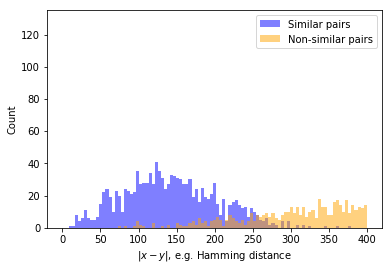

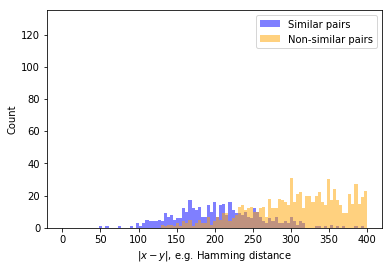

1424/1424 [==============================] - 0s 182us/step
2018-03-08 02:39:47,075 - root - DEBUG - [Iteration = 72] Training Loss = 92.81477301611956, Testing Loss = 121.49011310868049
2018-03-08 02:39:47,077 - root - DEBUG - Iteration 73 (current beta = 4770574165868.067)


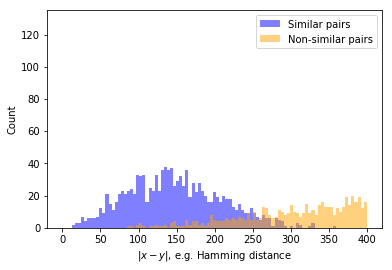

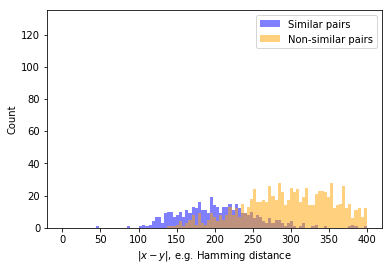

1424/1424 [==============================] - 0s 204us/step
2018-03-08 02:41:50,740 - root - DEBUG - [Iteration = 73] Training Loss = 109.12523715131259, Testing Loss = 155.8637800441631
2018-03-08 02:41:50,742 - root - DEBUG - Iteration 74 (current beta = 7155861248802.102)


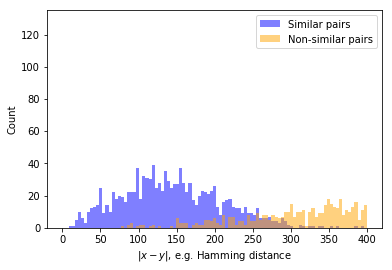

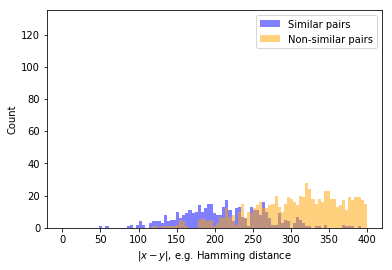

1424/1424 [==============================] - 0s 179us/step
2018-03-08 02:43:56,460 - root - DEBUG - [Iteration = 74] Training Loss = 90.00645333502226, Testing Loss = 111.9483473836392
2018-03-08 02:43:56,461 - root - DEBUG - Iteration 75 (current beta = 10733791873203.152)


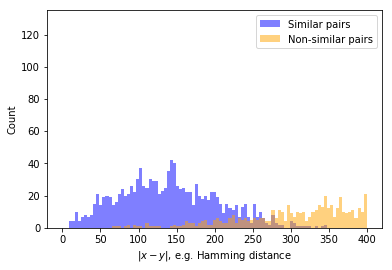

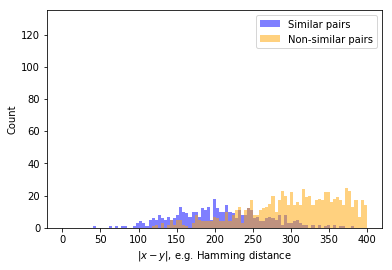

1424/1424 [==============================] - 0s 193us/step
2018-03-08 02:45:59,454 - root - DEBUG - [Iteration = 75] Training Loss = 93.76547132154084, Testing Loss = 130.13191922707745
2018-03-08 02:45:59,455 - root - DEBUG - Iteration 76 (current beta = 16100687809804.729)


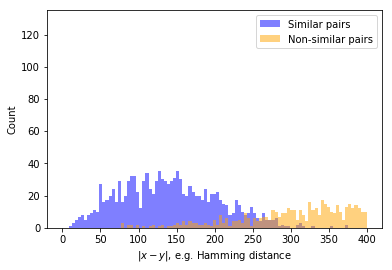

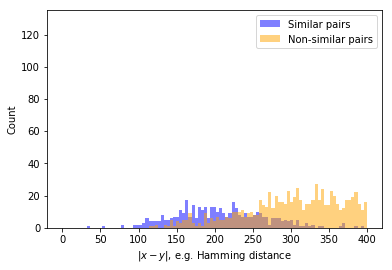

1424/1424 [==============================] - 0s 177us/step
2018-03-08 02:48:04,062 - root - DEBUG - [Iteration = 76] Training Loss = 95.09192640250703, Testing Loss = 137.23280798220023
2018-03-08 02:48:04,063 - root - DEBUG - Iteration 77 (current beta = 24151031714707.094)


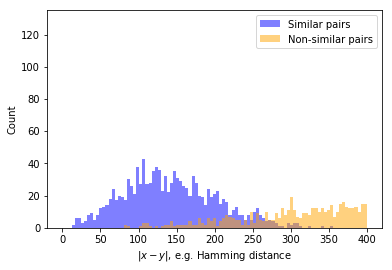

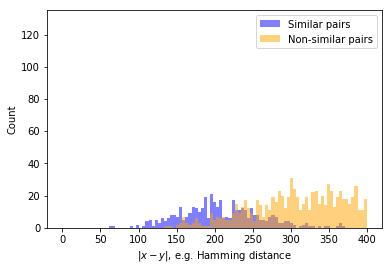

1424/1424 [==============================] - 0s 183us/step
2018-03-08 02:50:07,388 - root - DEBUG - [Iteration = 77] Training Loss = 100.97881440073057, Testing Loss = 131.37407837418337
2018-03-08 02:50:07,389 - root - DEBUG - Iteration 78 (current beta = 36226547572060.64)


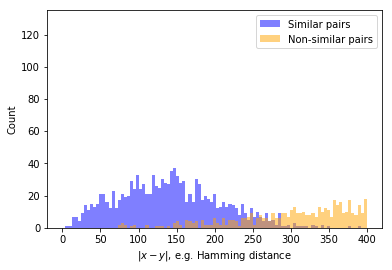

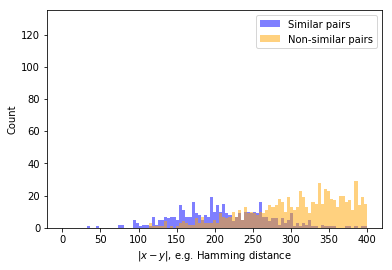

1424/1424 [==============================] - 0s 184us/step
2018-03-08 02:52:11,165 - root - DEBUG - [Iteration = 78] Training Loss = 87.18488956129282, Testing Loss = 107.69113568363062
2018-03-08 02:52:11,167 - root - DEBUG - Iteration 79 (current beta = 54339821358090.96)


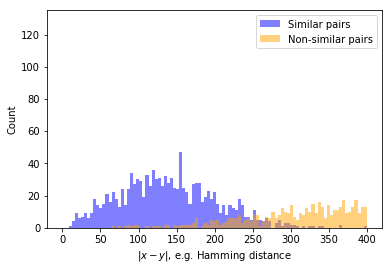

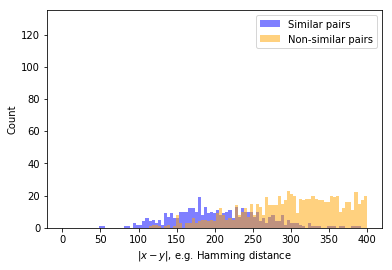

1424/1424 [==============================] - 0s 189us/step
2018-03-08 02:54:13,827 - root - DEBUG - [Iteration = 79] Training Loss = 89.88410119610175, Testing Loss = 125.36823875394262
2018-03-08 02:54:13,828 - root - DEBUG - Iteration 80 (current beta = 81509732037136.44)


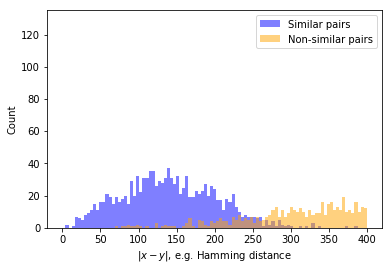

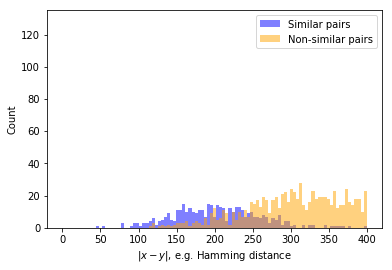

1424/1424 [==============================] - 0s 190us/step
2018-03-08 02:56:18,356 - root - DEBUG - [Iteration = 80] Training Loss = 92.772046495214, Testing Loss = 130.0373948701354
2018-03-08 02:56:18,358 - root - DEBUG - Iteration 81 (current beta = 122264598055704.66)


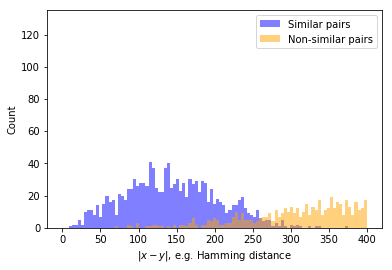

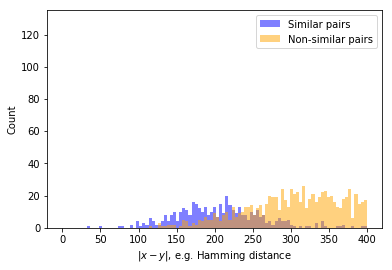

1424/1424 [==============================] - 0s 186us/step
2018-03-08 02:58:21,988 - root - DEBUG - [Iteration = 81] Training Loss = 95.80157486316998, Testing Loss = 130.9811823070154
2018-03-08 02:58:21,990 - root - DEBUG - Iteration 82 (current beta = 183396897083557.0)


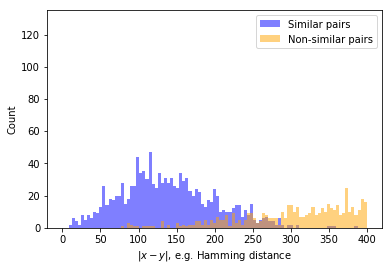

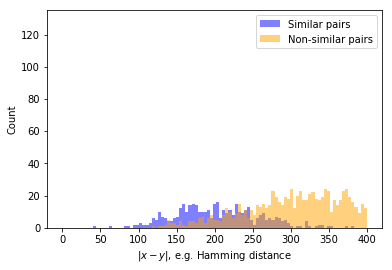

1424/1424 [==============================] - 0s 187us/step
2018-03-08 03:00:26,717 - root - DEBUG - [Iteration = 82] Training Loss = 98.61153271450664, Testing Loss = 142.1517363527706
2018-03-08 03:00:26,719 - root - DEBUG - Iteration 83 (current beta = 275095345625335.5)


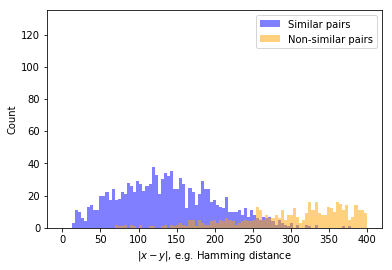

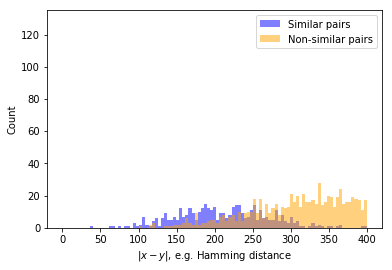

1424/1424 [==============================] - 0s 200us/step
2018-03-08 03:02:31,068 - root - DEBUG - [Iteration = 83] Training Loss = 89.06519510221153, Testing Loss = 110.68231215604236
2018-03-08 03:02:31,069 - root - DEBUG - Iteration 84 (current beta = 412643018438003.25)


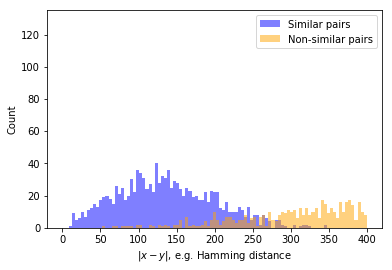

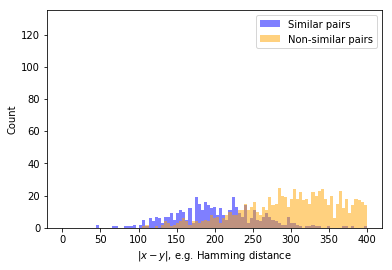

1424/1424 [==============================] - 0s 202us/step
2018-03-08 03:04:37,200 - root - DEBUG - [Iteration = 84] Training Loss = 97.55491169961226, Testing Loss = 144.47408652037456
2018-03-08 03:04:37,202 - root - DEBUG - Iteration 85 (current beta = 618964527657004.9)


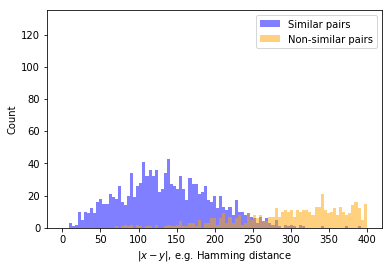

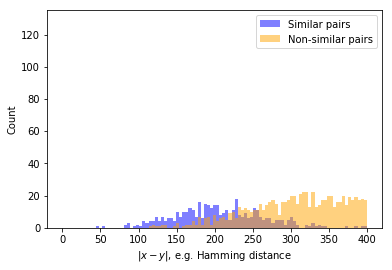

1424/1424 [==============================] - 0s 198us/step
2018-03-08 03:06:43,123 - root - DEBUG - [Iteration = 85] Training Loss = 95.49763405874361, Testing Loss = 120.57976785260306
2018-03-08 03:06:43,125 - root - DEBUG - Iteration 86 (current beta = 928446791485507.2)


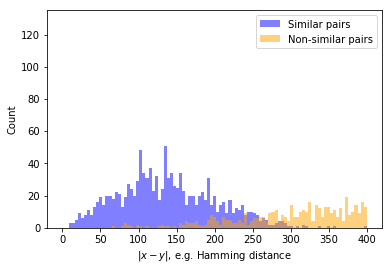

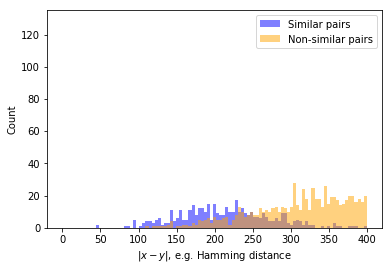

1424/1424 [==============================] - 0s 183us/step
2018-03-08 03:08:47,210 - root - DEBUG - [Iteration = 86] Training Loss = 94.82802902832712, Testing Loss = 110.24297190121679
2018-03-08 03:08:47,212 - root - DEBUG - Iteration 87 (current beta = 1392670187228261.0)


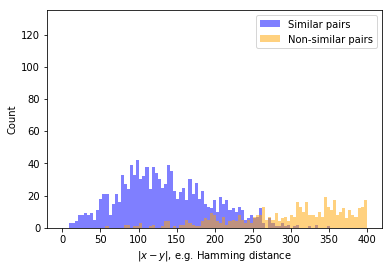

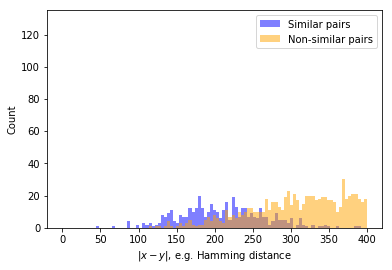

1424/1424 [==============================] - 0s 187us/step
2018-03-08 03:10:50,457 - root - DEBUG - [Iteration = 87] Training Loss = 100.66561170240288, Testing Loss = 122.16685527206786
2018-03-08 03:10:50,458 - root - DEBUG - Iteration 88 (current beta = 2089005280842391.5)


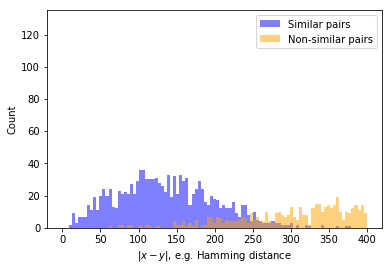

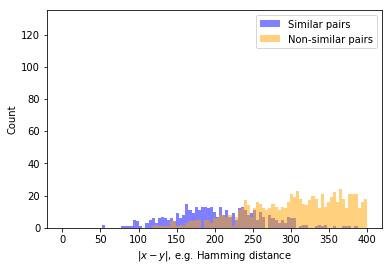

1424/1424 [==============================] - 0s 192us/step
2018-03-08 03:12:54,990 - root - DEBUG - [Iteration = 88] Training Loss = 96.19552176330103, Testing Loss = 129.05985999836983
2018-03-08 03:12:54,991 - root - DEBUG - Iteration 89 (current beta = 3133507921263587.0)


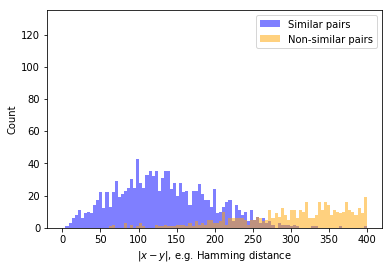

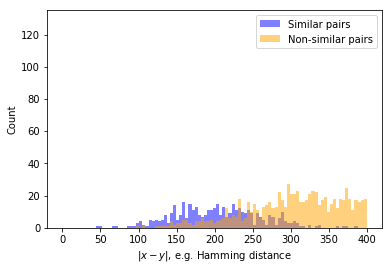

1424/1424 [==============================] - 0s 186us/step
2018-03-08 03:14:58,051 - root - DEBUG - [Iteration = 89] Training Loss = 98.8482015076203, Testing Loss = 137.62128986923673
2018-03-08 03:14:58,052 - root - DEBUG - Iteration 90 (current beta = 4700261881895380.0)


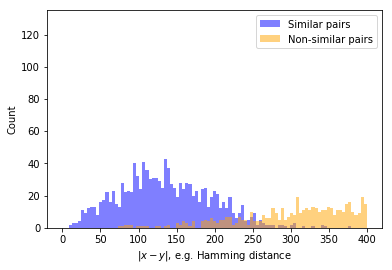

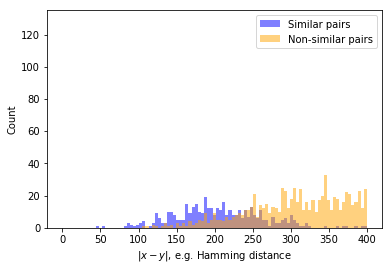

1424/1424 [==============================] - 0s 181us/step
2018-03-08 03:17:02,654 - root - DEBUG - [Iteration = 90] Training Loss = 94.35897895420543, Testing Loss = 118.02011923594505
2018-03-08 03:17:02,655 - root - DEBUG - Iteration 91 (current beta = 7050392822843070.0)


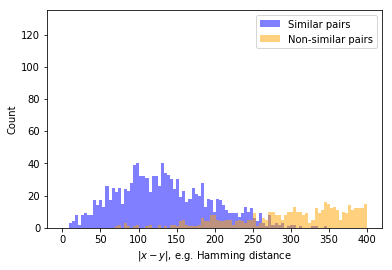

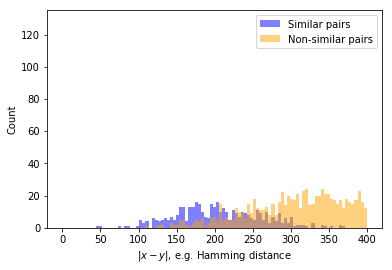

1424/1424 [==============================] - 0s 189us/step
2018-03-08 03:19:04,727 - root - DEBUG - [Iteration = 91] Training Loss = 97.1890803028291, Testing Loss = 130.4140815343734
2018-03-08 03:19:04,728 - root - DEBUG - Iteration 92 (current beta = 1.0575589234264604e+16)


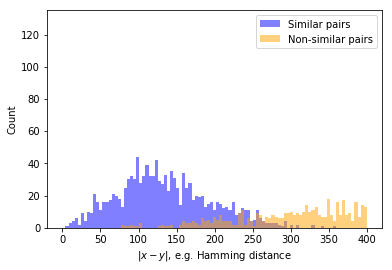

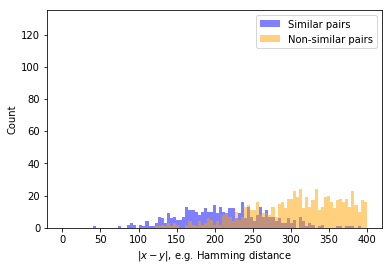

1424/1424 [==============================] - 0s 177us/step
2018-03-08 03:21:08,061 - root - DEBUG - [Iteration = 92] Training Loss = 93.46246099887796, Testing Loss = 103.80253498444564
2018-03-08 03:21:08,062 - root - DEBUG - Iteration 93 (current beta = 1.5863383851396906e+16)


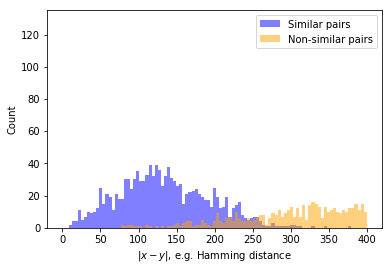

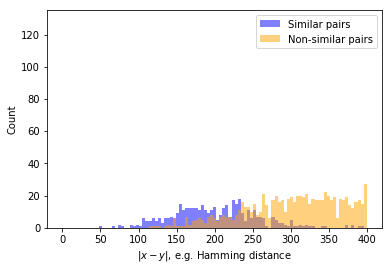

1424/1424 [==============================] - 0s 177us/step
2018-03-08 03:23:09,081 - root - DEBUG - [Iteration = 93] Training Loss = 98.43364623723834, Testing Loss = 126.54161966439818
2018-03-08 03:23:09,082 - root - DEBUG - Iteration 94 (current beta = 2.379507577709536e+16)


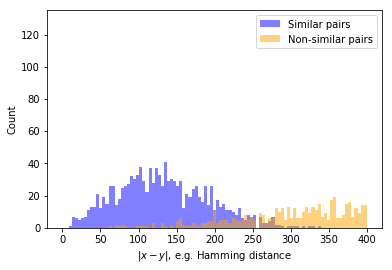

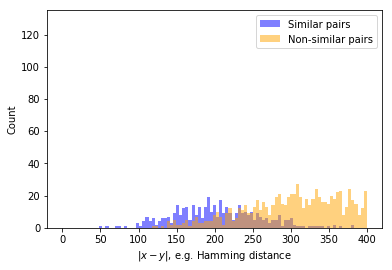

1424/1424 [==============================] - 0s 180us/step
2018-03-08 03:25:12,388 - root - DEBUG - [Iteration = 94] Training Loss = 100.54101664747077, Testing Loss = 137.5808195926542
2018-03-08 03:25:12,389 - root - DEBUG - Iteration 95 (current beta = 3.569261366564304e+16)


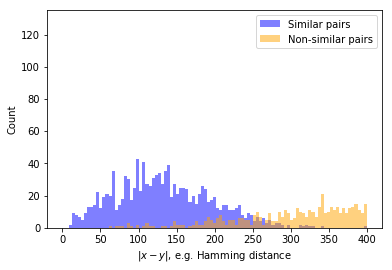

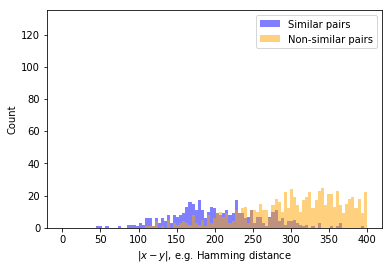

1424/1424 [==============================] - 0s 170us/step
2018-03-08 03:27:12,956 - root - DEBUG - [Iteration = 95] Training Loss = 95.81619432990468, Testing Loss = 128.32891003930357
2018-03-08 03:27:12,957 - root - DEBUG - Iteration 96 (current beta = 5.353892049846456e+16)


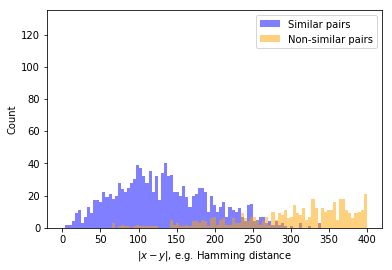

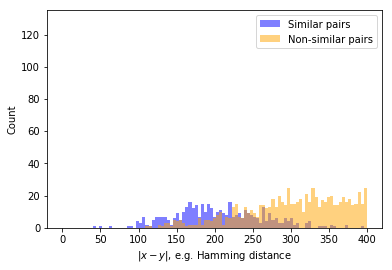

1424/1424 [==============================] - 0s 180us/step
2018-03-08 03:29:16,229 - root - DEBUG - [Iteration = 96] Training Loss = 95.96012429484796, Testing Loss = 130.5753778779717
2018-03-08 03:29:16,231 - root - DEBUG - Iteration 97 (current beta = 8.030838074769683e+16)


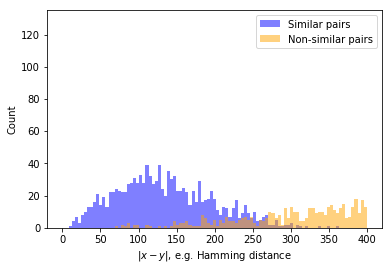

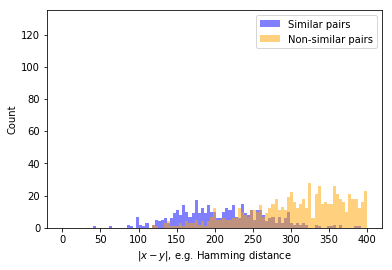

1424/1424 [==============================] - 0s 183us/step
2018-03-08 03:31:17,615 - root - DEBUG - [Iteration = 97] Training Loss = 89.67951028538766, Testing Loss = 111.268656064526
2018-03-08 03:31:17,617 - root - DEBUG - Iteration 98 (current beta = 1.2046257112154525e+17)


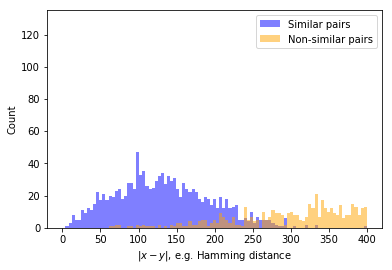

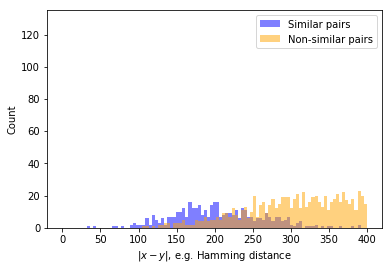

1424/1424 [==============================] - 0s 185us/step
2018-03-08 03:33:22,909 - root - DEBUG - [Iteration = 98] Training Loss = 98.00436321258786, Testing Loss = 136.10754957956817
2018-03-08 03:33:22,911 - root - DEBUG - Iteration 99 (current beta = 1.806938566823179e+17)


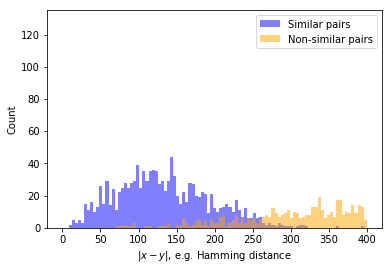

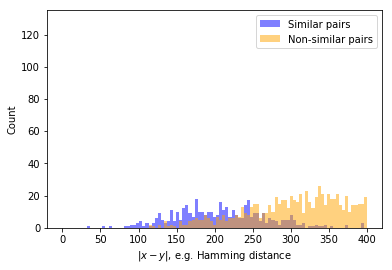

1424/1424 [==============================] - 0s 174us/step
2018-03-08 03:35:25,185 - root - DEBUG - [Iteration = 99] Training Loss = 93.1801409523821, Testing Loss = 117.97238027485443
2018-03-08 03:35:25,186 - root - DEBUG - Iteration 100 (current beta = 2.7104078502347683e+17)


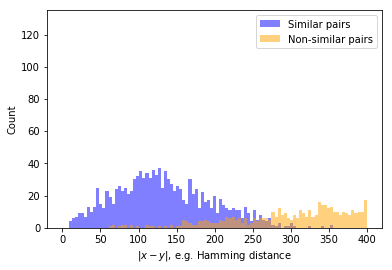

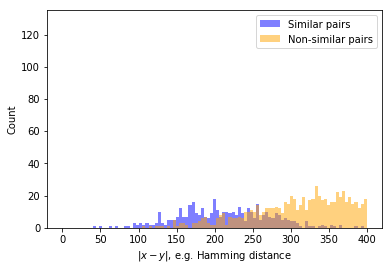

1424/1424 [==============================] - 0s 179us/step
2018-03-08 03:37:30,314 - root - DEBUG - [Iteration = 100] Training Loss = 95.87626196167808, Testing Loss = 115.95759030305938


In [35]:
for m in range(1, number_of_iterations+1):
    logger.debug("Iteration {:} (current beta = {:})".format(m, beta))
    
    # Train a model with 4 inputs and 1 dummy output.
    model.fit({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S], verbose=verbose, epochs=number_of_epochs)
    beta *= beta_factor
    
    representation_model = Model(image_a, encoded_a)
    visualize(X1, X2, groundTruth, representation_model)
    visualize(X1_val, X2_val, groundTruth_val, representation_model)
#     visualizeFilters()
    
    train_loss = model.evaluate({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S])
    test_loss  = model.evaluate({'image_1': X1_val, 'image_2': X2_val, 'similarity': S_val, 'weight': W_val}, [S_val])
    logger.debug("[Iteration = {:}] Training Loss = {:}, Testing Loss = {:}".format(m, train_loss, test_loss))
    train_losses.append(train_loss)
    test_losses.append(test_loss)

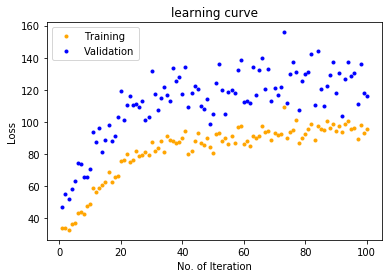

In [36]:
plt.figure()
plt.title("learning curve")
plt.plot(range(1,len(train_losses)+1), train_losses, '.', color='orange', label='Training')
plt.plot(range(1,len(test_losses)+1), test_losses, '.', color='blue', label='Validation')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("No. of Iteration")
plt.show()

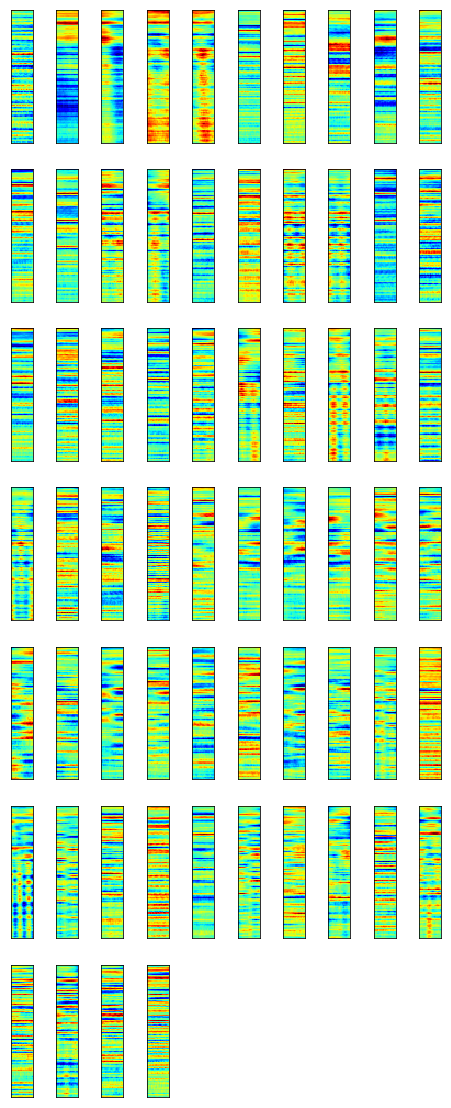

In [37]:
visualizeFilters()

## Save Model

In [38]:
MODEL_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "[Iteration={:}]".format(number_of_iterations)
logger.debug("Save model to {:}.h5".format(MODEL_NAME))
model.save(MODEL_NAME + ".h5")

2018-03-08 03:37:34,579 - root - DEBUG - Save model to 2018-03-08[HashNet-100-iteration-dropout-80-batchnorm][Iteration=100].h5


## Visualize Performance 

__Obtain a representation model__

This representation model is the same as the trained model above without the loss layer at the very end.

In [39]:
representation_model = Model(image_a, encoded_a)

ValueError: cannot reshape array of size 768 into shape (32,16)

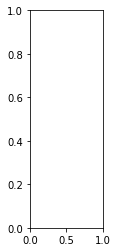

In [40]:
# Get sample output
# Reshaped to be (32,16) for visualization purposes.
pred_X1 = representation_model.predict(X1)
plt.subplot(1,4,1)
plt.imshow(pred_X1[:1].reshape(32,16) > 0)
plt.subplot(1,4,2)
plt.imshow(pred_X1[1:2].reshape(32,16) > 0)
plt.subplot(1,4,3)
plt.imshow(pred_X1[2:3].reshape(32,16) > 0)
plt.subplot(1,4,4)
plt.imshow(pred_X1[3:4].reshape(32,16) > 0)
plt.show()

## Evaluate Performance
Calculate the hamming distance input pairs and plot the corresponding histogram.

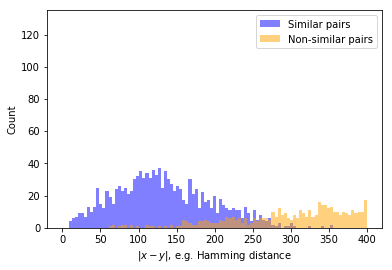

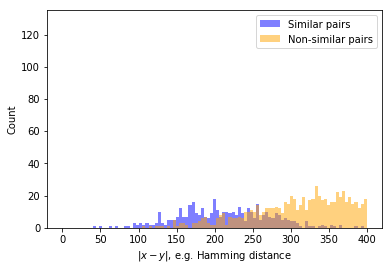

In [41]:
representation_model = Model(image_a, encoded_a)
visualize(X1, X2, groundTruth, representation_model)
visualize(X1_val, X2_val, groundTruth_val, representation_model)

## Appendix: Architecture Details

In [42]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_1 (InputLayer)            (None, 1, 76, 121)   0                                            
__________________________________________________________________________________________________
image_2 (InputLayer)            (None, 1, 76, 121)   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 12, 1)    154884      image_1[0][0]                    
                                                                 image_2[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 768)          0           sequential_1[1][0]               
__________

In [43]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 12, 1)         154880    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 12, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 12, 1)         4         
Total params: 154,884
Trainable params: 154,882
Non-trainable params: 2
_________________________________________________________________
